In [1]:
#importing necessary packages
!pip install optuna
import optuna
import torch
import random
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch.nn.functional as F
from csv import writer
import seaborn as sns
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torchsde or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
'''# if running with Google Colab, enter the right path from your Drive
# otherwise completely comment this cell

from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/Othercomputers/My MacBook Pro (1)/LearningEulersElastica/DiscreteNetwork"'''

'# if running with Google Colab, enter the right path from your Drive\n# otherwise completely comment this cell\n\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n%cd "/content/drive/Othercomputers/My MacBook Pro (1)/LearningEulersElastica/DiscreteNetwork"'

In [3]:
from Scripts.GetData import getDataLoaders, loadData
from Scripts.Training import train
from Scripts.PlotResults import plotResults
from Scripts.SavedParameters import hyperparams

In [4]:
#setting plotting parameters
sns.set_style("darkgrid")
sns.set(font = "Times New Roman")
sns.set_context("paper")
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt_kws = {"rasterized": True}

In [5]:
torch.set_default_dtype(torch.float32)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
# both-ends only: datacase == 1
# train on both-ends, test on right-end: datacase == 2
# train and test on both-ends + right-end: datacase == 3

datacase = input("Choose datacase ")
datacase = int(datacase)

In [8]:
if datacase == 1:
    percentage_train = input("Choose percentage of training data between 90, 40, 20, and 10: ")
    percentage_train = int(percentage_train)/100
    percentage_train
else:
    percentage_train = 0.8

In [9]:
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)

In [10]:
class approximate_curve(nn.Module):
        def __init__(self, is_res = True, normalize = True, act_name='tanh', nlayers=3, hidden_nodes = 50, output_dim = 204):
          super().__init__()

          torch.manual_seed(1)
          np.random.seed(1)
          random.seed(1)
          self.act_dict = {"tanh":lambda x : torch.tanh(x),
                            "sigmoid":lambda x : torch.sigmoid(x),
                            "swish":lambda x : x*torch.sigmoid(x),
                            "relu":lambda x : torch.relu(x),
                            "lrelu":lambda x : F.leaky_relu(x)}
          self.is_norm = normalize
          self.is_res = is_res
          self.act = self.act_dict[act_name]
          self.nlayers = nlayers
          self.first = nn.Linear(8,hidden_nodes)
          self.linears = nn.ModuleList([nn.Linear(hidden_nodes,hidden_nodes) for i in range(self.nlayers)])
          self.last = nn.Linear(hidden_nodes,output_dim)

        def forward(self,x):

            if self.is_norm:
                x[:,0] = (x[:,0]-1.5)/1.5
                x[:,4] = (x[:,4]-1.5)/1.5
            x  = self.act(self.first(x))
            for i in range(self.nlayers):
                if self.is_res: #ResNet
                    x = x + self.act(self.linears[i](x))
                else: #MLP
                    x = self.act(self.linears[i](x))

            return self.last(x)

In [11]:
num_nodes, _,_ = loadData(datacase)

In [12]:
def define_model(trial):
    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)
    is_res = False #trial.suggest_categorical("is_res",[True,False])
    normalize = True #trial.suggest_categorical("normalize",[True,False])
    act_name = "tanh" #trial.suggest_categorical("act",['tanh','swish','sigmoid','relu','lrelu'])
    nlayers = trial.suggest_int("n_layers", 0, 4)
    hidden_nodes = trial.suggest_int("hidden_nodes", 500, 1000)

    model = approximate_curve(is_res, normalize, act_name, nlayers, hidden_nodes,output_dim=int(4*(num_nodes-2)))
    return model

In [13]:
from torch.utils.data import Dataset, DataLoader

In [14]:
def objective(trial):

    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)

    # Generate the model
    model = define_model(trial)
    model.to(device);

    lr = 1e-3 #trial.suggest_float("lr", 1e-4 , 1e-1, log=True)
    weight_decay = 0 #trial.suggest_float("weight_decay",1e-7,5e-4,log=True)
    gamma = trial.suggest_float("gamma",0,1e-2) #smoothing regularization
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)

    criterion = nn.MSELoss()

    batch_size = 32 #trial.suggest_categorical("batch_size", [32, 64, 128])
    _, _, _, _, x_val,y_val,trainloader,_,valloader = getDataLoaders(batch_size, datacase, percentage_train)

    print("Current test with :\n\n")
    for key, value in trial.params.items():
      print("    {}: {}".format(key, value))
    print("\n\n")

    epochs = 300
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = int(0.45*epochs), gamma = 0.1)
    
    loss = train(model,gamma,criterion,scheduler,optimizer,epochs,trainloader,valloader,device)
    print('Loss ',loss.item())
    error = 1000

    if not torch.isnan(loss):
        model.eval();

        learned_traj = np.zeros_like(y_val)
        
        bcs_val = torch.from_numpy(x_val.astype(np.float32)).to(device)
        learned_traj = model(bcs_val).detach().cpu().numpy()
        error = np.mean((learned_traj-y_val)**2)

        print(f"The error on the validation trajectories is: {error}.")


    datanames = ["both_ends", "both_ends_right_end"]
    if datacase == 1:
        dataname = datanames[0]
    if datacase == 3:
        dataname = datanames[1]

    #Saving the obtained results
    if trial.number == 0:
        labels = []
        for lab, _ in trial.params.items():
            labels.append(str(lab))
        labels.append("MSE")
        with open("SavedResults.csv", "a") as f_object:
            writer_object = writer(f_object)
            writer_object.writerow(labels)
            writer_object.writerow(f"\n\n Datacase: {dataname}, Percentage of training data: {percentage_train}")
            f_object.close()

    results = []
    for _, value in trial.params.items():
        results.append(str(value))

    results.append(error)

    with open("SavedResults.csv", "a") as f_object:
        writer_object = writer(f_object)
        writer_object.writerow(results)
        f_object.close()
    return error

[I 2024-04-25 18:13:25,734] A new study created in memory with name: Euler Elastica


train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 1
    hidden_nodes: 709
    gamma: 0.00918159270397557



The average loss in epoch 1 is  0.15885297420688652
The average loss in epoch 2 is  0.02116423324597153
The average loss in epoch 3 is  0.010723932159387252
The average loss in epoch 4 is  0.0075737341010773725
The average loss in epoch 5 is  0.0065352263098413296
The average loss in epoch 6 is  0.004641298183493994
The average loss in epoch 7 is  0.0037206218456214465
The average loss in epoch 8 is  0.003626265060368248
The average loss in epoch 9 is  0.0024423436843790114
The average loss in epoch 10 is  0.002321931856303391
The average loss in epoch 11 is  0.002247772465290671
The average loss in epoch 12 is  0.0021091783128213137
The average loss in epoch 13 is  0.0022572496567260136
The average loss in epoch 14 is  0.0016707693959522824
The average loss in epoch 15 is  0.0018071517036084763
The average loss in epoch 16 is  0.0015472752909

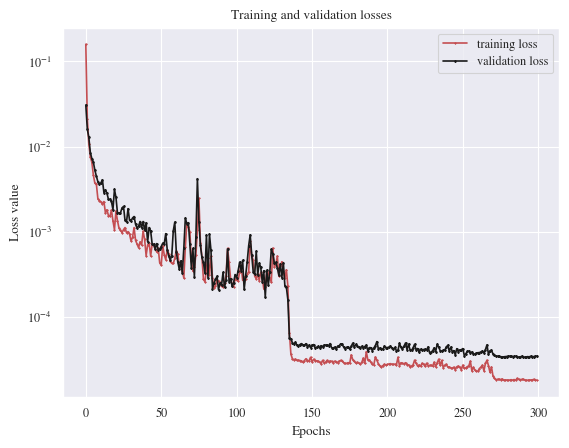

[I 2024-04-25 18:14:08,760] Trial 0 finished with value: 3.444431178966561e-05 and parameters: {'n_layers': 1, 'hidden_nodes': 709, 'gamma': 0.00918159270397557}. Best is trial 0 with value: 3.444431178966561e-05.


Loss  3.96241284761345e-06
The error on the validation trajectories is: 3.444431178966561e-05.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 1
    hidden_nodes: 873
    gamma: 0.008293599280409032



The average loss in epoch 1 is  0.1453937217593193
The average loss in epoch 2 is  0.020609846931289543
The average loss in epoch 3 is  0.01042023912834173
The average loss in epoch 4 is  0.0069708774522454905
The average loss in epoch 5 is  0.006723211718384515
The average loss in epoch 6 is  0.005024853151884268
The average loss in epoch 7 is  0.003658711685354567
The average loss in epoch 8 is  0.0038036212949505584
The average loss in epoch 9 is  0.002502056484279985
The average loss in epoch 10 is  0.002265108098402958
The average loss in epoch 11 is  0.0021784987157761034
The average loss in epoch 12 is  0.002103324164636433
The average loss in epoch 13 is  0.002206034124934707
The average loss in epoch 14 is  0.0016073565877212043
The average

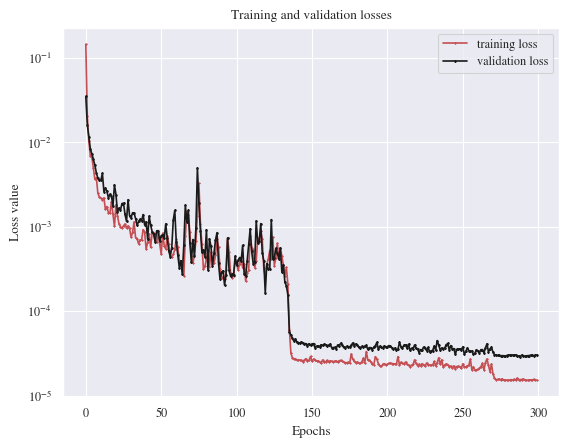

[I 2024-04-25 18:15:00,580] Trial 1 finished with value: 3.021704044129479e-05 and parameters: {'n_layers': 1, 'hidden_nodes': 873, 'gamma': 0.008293599280409032}. Best is trial 1 with value: 3.021704044129479e-05.


Loss  3.998745796707226e-06
The error on the validation trajectories is: 3.021704044129479e-05.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 639
    gamma: 0.0074490499710950136



The average loss in epoch 1 is  0.16507294503125278
The average loss in epoch 2 is  0.01809827403419397
The average loss in epoch 3 is  0.014363650147887793
The average loss in epoch 4 is  0.010187017646702852
The average loss in epoch 5 is  0.0062935859578746286
The average loss in epoch 6 is  0.007055951229465956
The average loss in epoch 7 is  0.007031480284323069
The average loss in epoch 8 is  0.003969292844307016
The average loss in epoch 9 is  0.0021691206308208743
The average loss in epoch 10 is  0.0015423713590611112
The average loss in epoch 11 is  0.0012191287241876125
The average loss in epoch 12 is  0.0005688162980897522
The average loss in epoch 13 is  0.0006481199201185849
The average loss in epoch 14 is  0.0009363061491802165
The a

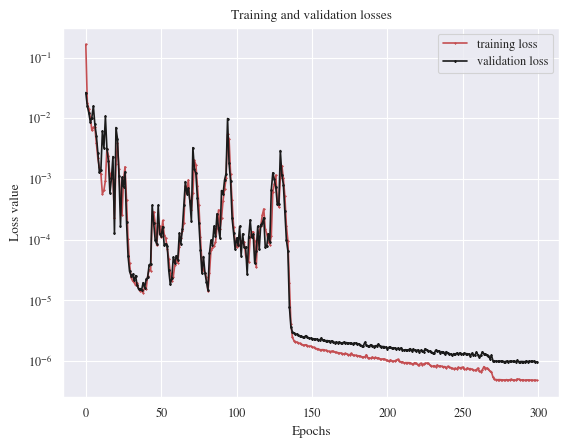

[I 2024-04-25 18:16:40,073] Trial 2 finished with value: 9.587129491163915e-07 and parameters: {'n_layers': 4, 'hidden_nodes': 639, 'gamma': 0.0074490499710950136}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  2.2539441602020815e-07
The error on the validation trajectories is: 9.587129491163915e-07.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 3
    hidden_nodes: 899
    gamma: 0.0013832021787684402



The average loss in epoch 1 is  0.14750917653807186
The average loss in epoch 2 is  0.014541098763319578
The average loss in epoch 3 is  0.007901617569256236
The average loss in epoch 4 is  0.0035618626332672484
The average loss in epoch 5 is  0.004888990931001238
The average loss in epoch 6 is  0.00384320303353227
The average loss in epoch 7 is  0.004955112283245067
The average loss in epoch 8 is  0.0014098365023859185
The average loss in epoch 9 is  0.0014266508514992893
The average loss in epoch 10 is  0.0009750768222147599
The average loss in epoch 11 is  0.0010480537060754034
The average loss in epoch 12 is  0.0016072563686810265
The average loss in epoch 13 is  0.0009390614193927666
The average loss in epoch 14 is  0.0022726639012530954
The

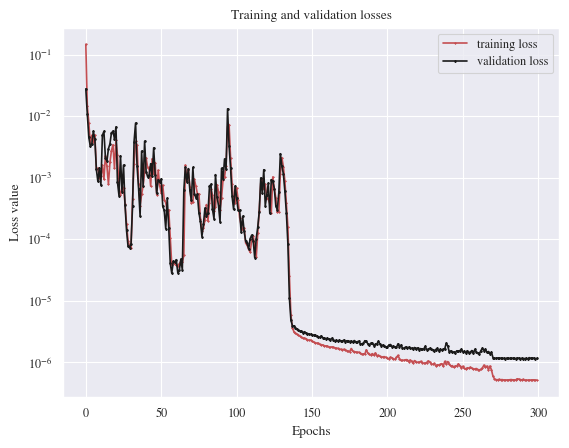

[I 2024-04-25 18:18:54,356] Trial 3 finished with value: 1.1538722395042293e-06 and parameters: {'n_layers': 3, 'hidden_nodes': 899, 'gamma': 0.0013832021787684402}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  2.06218416565207e-07
The error on the validation trajectories is: 1.1538722395042293e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 0
    hidden_nodes: 688
    gamma: 0.00407952555013127



The average loss in epoch 1 is  0.2455025493082675
The average loss in epoch 2 is  0.030033677647059612
The average loss in epoch 3 is  0.016472406304356726
The average loss in epoch 4 is  0.01392444695176726
The average loss in epoch 5 is  0.013811017111451789
The average loss in epoch 6 is  0.012746220412240787
The average loss in epoch 7 is  0.01229972925714471
The average loss in epoch 8 is  0.011135746661404317
The average loss in epoch 9 is  0.010301020970060066
The average loss in epoch 10 is  0.010029047283089974
The average loss in epoch 11 is  0.01031839883547615
The average loss in epoch 12 is  0.009622366379269144
The average loss in epoch 13 is  0.009406436192379757
The average loss in epoch 14 is  0.008838955566964367
The average loss 

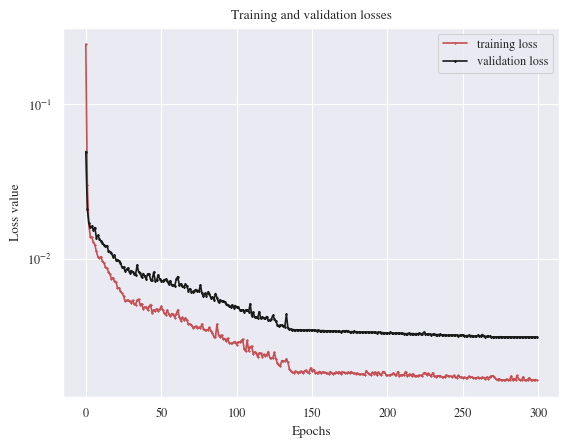

[I 2024-04-25 18:19:12,854] Trial 4 finished with value: 0.003103503764954699 and parameters: {'n_layers': 0, 'hidden_nodes': 688, 'gamma': 0.00407952555013127}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  0.0004156584618613124
The error on the validation trajectories is: 0.003103503764954699.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 1
    hidden_nodes: 742
    gamma: 0.005713842271155899



The average loss in epoch 1 is  0.15799070911651308
The average loss in epoch 2 is  0.02138358037072149
The average loss in epoch 3 is  0.010724588868800889
The average loss in epoch 4 is  0.007583637716544961
The average loss in epoch 5 is  0.006690532265400345
The average loss in epoch 6 is  0.004706680340777067
The average loss in epoch 7 is  0.0037187384785449303
The average loss in epoch 8 is  0.0037406746361573987
The average loss in epoch 9 is  0.0024386025351387534
The average loss in epoch 10 is  0.0022619936895683745
The average loss in epoch 11 is  0.002200419091175056
The average loss in epoch 12 is  0.0020791020916393873
The average loss in epoch 13 is  0.002197808937952769
The average loss in epoch 14 is  0.0016457327609797094
The aver

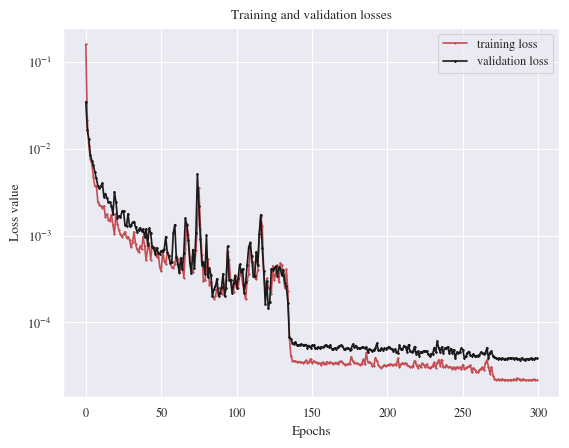

[I 2024-04-25 18:20:04,069] Trial 5 finished with value: 3.866868107262562e-05 and parameters: {'n_layers': 1, 'hidden_nodes': 742, 'gamma': 0.005713842271155899}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  5.478221282828599e-06
The error on the validation trajectories is: 3.866868107262562e-05.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 3
    hidden_nodes: 678
    gamma: 0.009940379055768219



The average loss in epoch 1 is  0.15754301837560805
The average loss in epoch 2 is  0.017040919089181858
The average loss in epoch 3 is  0.009223512691360984
The average loss in epoch 4 is  0.0034432461093687875
The average loss in epoch 5 is  0.005002358748408204
The average loss in epoch 6 is  0.004023464703509076
The average loss in epoch 7 is  0.0048517652109942655
The average loss in epoch 8 is  0.0015379675129555505
The average loss in epoch 9 is  0.0013225506038658998
The average loss in epoch 10 is  0.0009642276920865036
The average loss in epoch 11 is  0.0009970443444961513
The average loss in epoch 12 is  0.0013186114738346078
The average loss in epoch 13 is  0.0010737593488143334
The average loss in epoch 14 is  0.0014718081904654603
The

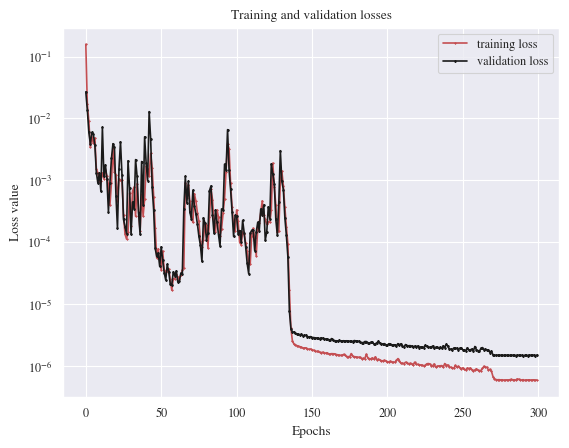

[I 2024-04-25 18:21:43,274] Trial 6 finished with value: 1.5107518554137158e-06 and parameters: {'n_layers': 3, 'hidden_nodes': 678, 'gamma': 0.009940379055768219}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  2.552478122197499e-07
The error on the validation trajectories is: 1.5107518554137158e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 1
    hidden_nodes: 995
    gamma: 0.0011269978021994764



The average loss in epoch 1 is  0.14271704480051994
The average loss in epoch 2 is  0.019356236327439547
The average loss in epoch 3 is  0.009091475174169649
The average loss in epoch 4 is  0.006125637076117776
The average loss in epoch 5 is  0.005988673021254892
The average loss in epoch 6 is  0.005685007305477153
The average loss in epoch 7 is  0.0033210249411323193
The average loss in epoch 8 is  0.0035969904063015497
The average loss in epoch 9 is  0.0025000334161714736
The average loss in epoch 10 is  0.00207220949894029
The average loss in epoch 11 is  0.002006511648439548
The average loss in epoch 12 is  0.0019864585986149245
The average loss in epoch 13 is  0.0018888938066083938
The average loss in epoch 14 is  0.0014282132932831619
The a

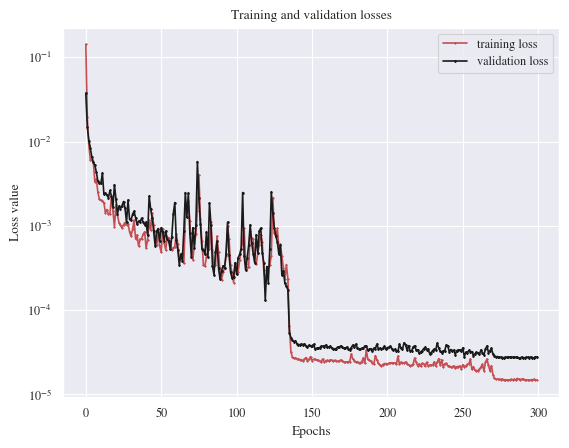

[I 2024-04-25 18:23:29,890] Trial 7 finished with value: 2.7810627810458103e-05 and parameters: {'n_layers': 1, 'hidden_nodes': 995, 'gamma': 0.0011269978021994764}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  4.192034793959465e-06
The error on the validation trajectories is: 2.7810627810458103e-05.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 527
    gamma: 0.007471166149072553



The average loss in epoch 1 is  0.18800763294778086
The average loss in epoch 2 is  0.019608897749673237
The average loss in epoch 3 is  0.014321121937510643
The average loss in epoch 4 is  0.012698885349726135
The average loss in epoch 5 is  0.012343973979692568
The average loss in epoch 6 is  0.00994646504775367
The average loss in epoch 7 is  0.005632705076343634
The average loss in epoch 8 is  0.0018952116184994918
The average loss in epoch 9 is  0.0031849239391952074
The average loss in epoch 10 is  0.0031590947500345383
The average loss in epoch 11 is  0.0016353777477475392
The average loss in epoch 12 is  0.0006476741400547326
The average loss in epoch 13 is  0.00043622342656652273
The average loss in epoch 14 is  0.0014362231638435994
The 

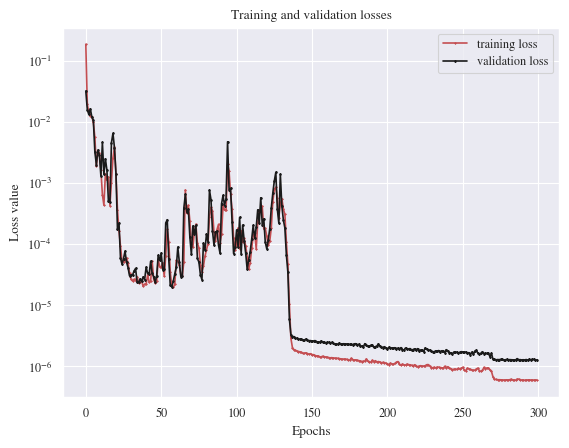

[I 2024-04-25 18:25:10,492] Trial 8 finished with value: 1.2661849223549921e-06 and parameters: {'n_layers': 4, 'hidden_nodes': 527, 'gamma': 0.007471166149072553}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  2.6944925934913044e-07
The error on the validation trajectories is: 1.2661849223549921e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 3
    hidden_nodes: 838
    gamma: 0.008681108798849466



The average loss in epoch 1 is  0.1444122064858675
The average loss in epoch 2 is  0.014610420065847311
The average loss in epoch 3 is  0.008393441570330073
The average loss in epoch 4 is  0.003821361513639038
The average loss in epoch 5 is  0.004173301139169119
The average loss in epoch 6 is  0.0033348725939338856
The average loss in epoch 7 is  0.005068633345548402
The average loss in epoch 8 is  0.0014818451176820831
The average loss in epoch 9 is  0.00136336616626729
The average loss in epoch 10 is  0.0007806921381746757
The average loss in epoch 11 is  0.0010494542240683752
The average loss in epoch 12 is  0.0018011542739590038
The average loss in epoch 13 is  0.0007737145259108564
The average loss in epoch 14 is  0.001727155975955115
The av

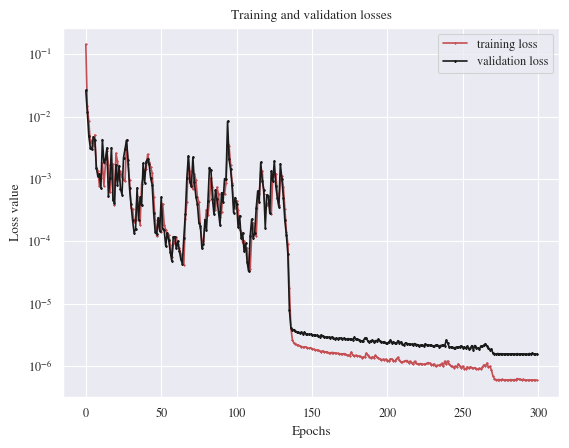

[I 2024-04-25 18:27:32,275] Trial 9 finished with value: 1.5415557870567345e-06 and parameters: {'n_layers': 3, 'hidden_nodes': 838, 'gamma': 0.008681108798849466}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  2.390432882748428e-07
The error on the validation trajectories is: 1.5415557870567345e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 559
    gamma: 0.006813691166730973



The average loss in epoch 1 is  0.1833171479573304
The average loss in epoch 2 is  0.01843341583894058
The average loss in epoch 3 is  0.01480925591154532
The average loss in epoch 4 is  0.011430433400991287
The average loss in epoch 5 is  0.008240123935551806
The average loss in epoch 6 is  0.005975467861968686
The average loss in epoch 7 is  0.0028837913255715234
The average loss in epoch 8 is  0.0013114257268501785
The average loss in epoch 9 is  0.002987407868865623
The average loss in epoch 10 is  0.0030532088950911366
The average loss in epoch 11 is  0.0018854077762543138
The average loss in epoch 12 is  0.0006772862490668723
The average loss in epoch 13 is  0.0003312841561802832
The average loss in epoch 14 is  0.0014908929641189222
The ave

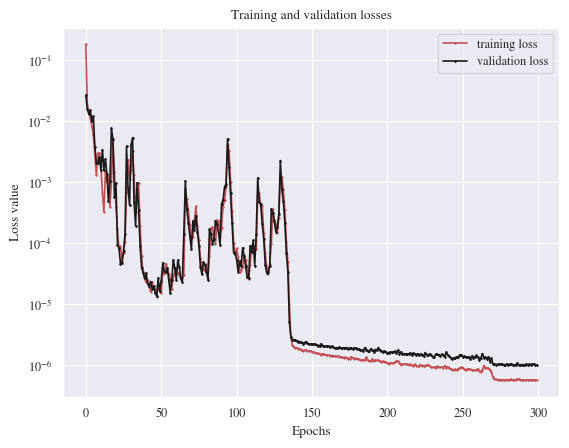

[I 2024-04-25 18:29:28,338] Trial 10 finished with value: 1.0091547422963823e-06 and parameters: {'n_layers': 4, 'hidden_nodes': 559, 'gamma': 0.006813691166730973}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  2.560375378379831e-07
The error on the validation trajectories is: 1.0091547422963823e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 552
    gamma: 0.006600680074931557



The average loss in epoch 1 is  0.177414296194911
The average loss in epoch 2 is  0.018175190314650536
The average loss in epoch 3 is  0.014510738578709688
The average loss in epoch 4 is  0.011283646104857326
The average loss in epoch 5 is  0.007844449909911915
The average loss in epoch 6 is  0.005825063774616204
The average loss in epoch 7 is  0.0027434802111449903
The average loss in epoch 8 is  0.001301108142466877
The average loss in epoch 9 is  0.0026791096686131573
The average loss in epoch 10 is  0.0029627224218777633
The average loss in epoch 11 is  0.0010654936817114833
The average loss in epoch 12 is  0.00030056126243752345
The average loss in epoch 13 is  0.0005269246000600767
The average loss in epoch 14 is  0.0009408767615571957
The a

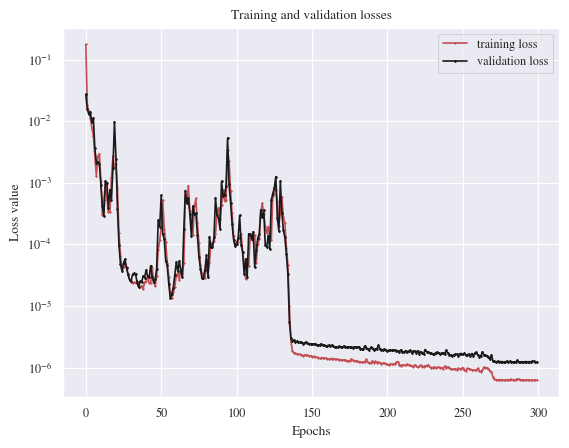

[I 2024-04-25 18:31:09,008] Trial 11 finished with value: 1.2195699958961143e-06 and parameters: {'n_layers': 4, 'hidden_nodes': 552, 'gamma': 0.006600680074931557}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  3.009525642028166e-07
The error on the validation trajectories is: 1.2195699958961143e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 602
    gamma: 0.006860575870941417



The average loss in epoch 1 is  0.16702409638938578
The average loss in epoch 2 is  0.017733455042947422
The average loss in epoch 3 is  0.014170695477249947
The average loss in epoch 4 is  0.009108093567192554
The average loss in epoch 5 is  0.0052371473601934585
The average loss in epoch 6 is  0.006895860985175453
The average loss in epoch 7 is  0.0036800394353287465
The average loss in epoch 8 is  0.0012003229825164783
The average loss in epoch 9 is  0.0015973045387495818
The average loss in epoch 10 is  0.000676164013301869
The average loss in epoch 11 is  0.0007386081296400251
The average loss in epoch 12 is  0.00026979527551289226
The average loss in epoch 13 is  0.0034100624222694683
The average loss in epoch 14 is  0.002913364891851829
The

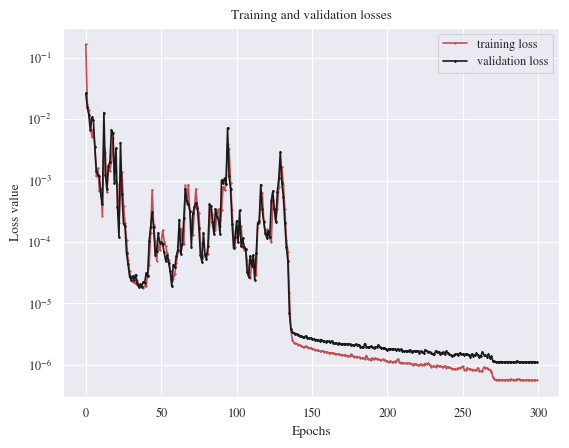

[I 2024-04-25 18:33:09,850] Trial 12 finished with value: 1.0893836418179153e-06 and parameters: {'n_layers': 4, 'hidden_nodes': 602, 'gamma': 0.006860575870941417}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  2.605104612030118e-07
The error on the validation trajectories is: 1.0893836418179153e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 3
    hidden_nodes: 614
    gamma: 0.004702190639715135



The average loss in epoch 1 is  0.16830440906977112
The average loss in epoch 2 is  0.01867957201532342
The average loss in epoch 3 is  0.01047574013302272
The average loss in epoch 4 is  0.004014459779930555
The average loss in epoch 5 is  0.005086973505306311
The average loss in epoch 6 is  0.004278461808677424
The average loss in epoch 7 is  0.0044158452232791615
The average loss in epoch 8 is  0.0013735998839944261
The average loss in epoch 9 is  0.0012948575551325287
The average loss in epoch 10 is  0.0009845250811353749
The average loss in epoch 11 is  0.0010007364127721469
The average loss in epoch 12 is  0.0014185165326290933
The average loss in epoch 13 is  0.0009341253799820234
The average loss in epoch 14 is  0.0009220178676927885
The a

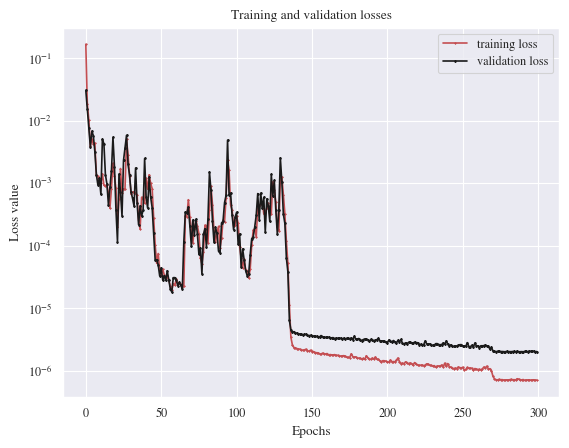

[I 2024-04-25 18:34:58,293] Trial 13 finished with value: 2.0247694957816696e-06 and parameters: {'n_layers': 3, 'hidden_nodes': 614, 'gamma': 0.004702190639715135}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  2.7202088404010283e-07
The error on the validation trajectories is: 2.0247694957816696e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 2
    hidden_nodes: 503
    gamma: 0.007628043787605899



The average loss in epoch 1 is  0.18909520723602988
The average loss in epoch 2 is  0.022615888917987995
The average loss in epoch 3 is  0.012127111348408189
The average loss in epoch 4 is  0.0070050876767543905
The average loss in epoch 5 is  0.005550371509426358
The average loss in epoch 6 is  0.003980393976565789
The average loss in epoch 7 is  0.0029419755658388817
The average loss in epoch 8 is  0.0025147095068611884
The average loss in epoch 9 is  0.0018341056949628348
The average loss in epoch 10 is  0.0018064371595921164
The average loss in epoch 11 is  0.0018212127377575432
The average loss in epoch 12 is  0.001278785169812512
The average loss in epoch 13 is  0.0013609797619706528
The average loss in epoch 14 is  0.0012573944206286053
Th

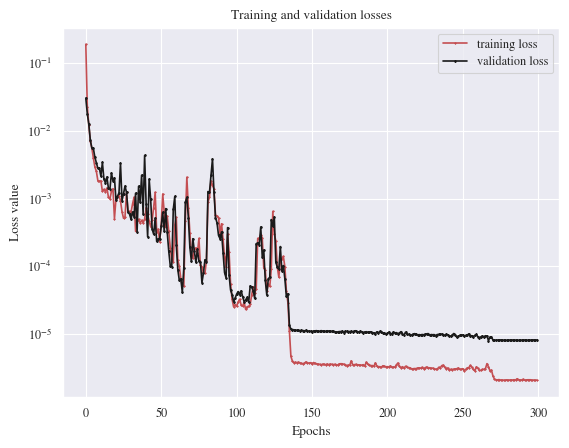

[I 2024-04-25 18:36:15,450] Trial 14 finished with value: 8.13965779689869e-06 and parameters: {'n_layers': 2, 'hidden_nodes': 503, 'gamma': 0.007628043787605899}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  1.0424557785881916e-06
The error on the validation trajectories is: 8.13965779689869e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 621
    gamma: 0.006053783517841173



The average loss in epoch 1 is  0.17231468847868117
The average loss in epoch 2 is  0.018481152851811865
The average loss in epoch 3 is  0.014706309842453762
The average loss in epoch 4 is  0.01094853461042724
The average loss in epoch 5 is  0.007162175860933282
The average loss in epoch 6 is  0.007292384472252293
The average loss in epoch 7 is  0.004531854223883288
The average loss in epoch 8 is  0.002219587651779875
The average loss in epoch 9 is  0.0015583336578195237
The average loss in epoch 10 is  0.0009348680773241954
The average loss in epoch 11 is  0.00108692824406634
The average loss in epoch 12 is  0.0004233432773617096
The average loss in epoch 13 is  0.0019908251488232054
The average loss in epoch 14 is  0.0013923921691126782
The avera

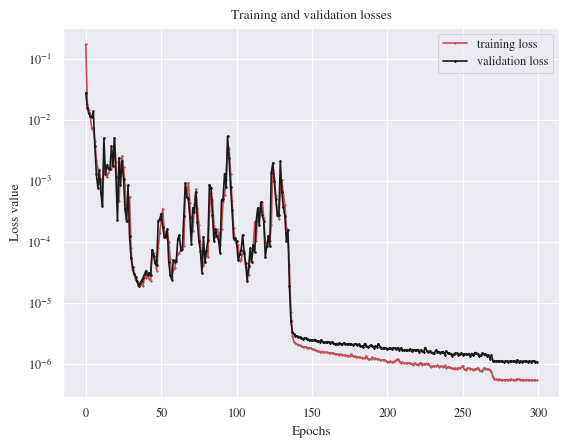

[I 2024-04-25 18:38:14,265] Trial 15 finished with value: 1.0784121388576873e-06 and parameters: {'n_layers': 4, 'hidden_nodes': 621, 'gamma': 0.006053783517841173}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  2.5069257958421076e-07
The error on the validation trajectories is: 1.0784121388576873e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 2
    hidden_nodes: 790
    gamma: 0.00382285006874775



The average loss in epoch 1 is  0.1505789408798922
The average loss in epoch 2 is  0.01795026008039713
The average loss in epoch 3 is  0.00823545778720555
The average loss in epoch 4 is  0.004151373207357458
The average loss in epoch 5 is  0.004157036627558145
The average loss in epoch 6 is  0.004523775476792996
The average loss in epoch 7 is  0.003535811577669599
The average loss in epoch 8 is  0.002037511950633912
The average loss in epoch 9 is  0.001594894600037316
The average loss in epoch 10 is  0.0014400993002874945
The average loss in epoch 11 is  0.0015300494137177752
The average loss in epoch 12 is  0.0009187037543266673
The average loss in epoch 13 is  0.0008880869030359794
The average loss in epoch 14 is  0.0011787291818605313
The avera

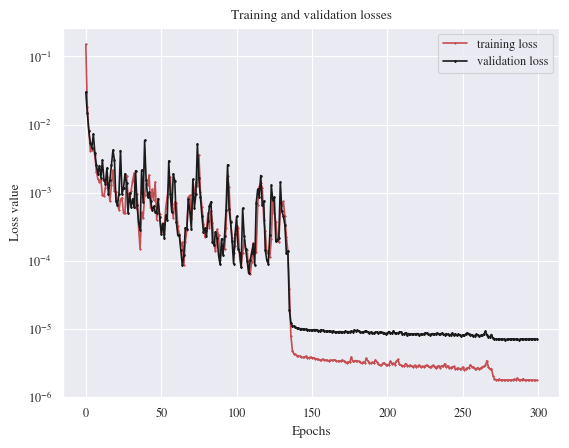

[I 2024-04-25 18:39:55,348] Trial 16 finished with value: 7.039990092465986e-06 and parameters: {'n_layers': 2, 'hidden_nodes': 790, 'gamma': 0.00382285006874775}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  6.415389748326561e-07
The error on the validation trajectories is: 7.039990092465986e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 581
    gamma: 0.007807460120278482



The average loss in epoch 1 is  0.17491642563519152
The average loss in epoch 2 is  0.017990098758177323
The average loss in epoch 3 is  0.014382068533450365
The average loss in epoch 4 is  0.010096707148477435
The average loss in epoch 5 is  0.005795084839602086
The average loss in epoch 6 is  0.006776785488579084
The average loss in epoch 7 is  0.0058580149462531235
The average loss in epoch 8 is  0.004469583747612143
The average loss in epoch 9 is  0.00235141029803675
The average loss in epoch 10 is  0.0015405188433677804
The average loss in epoch 11 is  0.001330510416830128
The average loss in epoch 12 is  0.00057372485951584
The average loss in epoch 13 is  0.00036707816252601333
The average loss in epoch 14 is  0.0008795942326700738
The avera

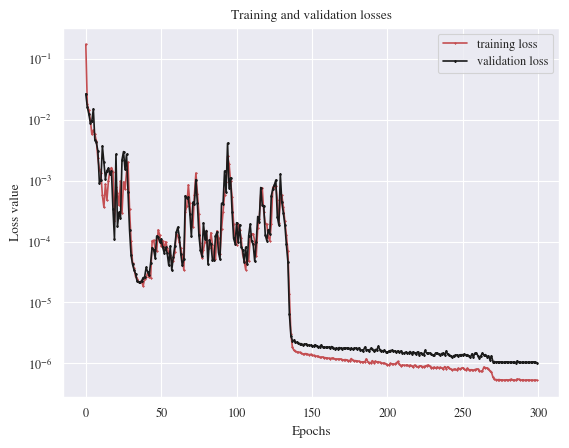

[I 2024-04-25 18:41:47,555] Trial 17 finished with value: 1.0273205994267053e-06 and parameters: {'n_layers': 4, 'hidden_nodes': 581, 'gamma': 0.007807460120278482}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  2.035273922729175e-07
The error on the validation trajectories is: 1.0273205994267053e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 3
    hidden_nodes: 635
    gamma: 0.005806738136936779



The average loss in epoch 1 is  0.15598308532075447
The average loss in epoch 2 is  0.017910158176991074
The average loss in epoch 3 is  0.010165378091518174
The average loss in epoch 4 is  0.003740173772464252
The average loss in epoch 5 is  0.004605462674093856
The average loss in epoch 6 is  0.004255562962498516
The average loss in epoch 7 is  0.004706367845012044
The average loss in epoch 8 is  0.0016305435962170702
The average loss in epoch 9 is  0.0013529155324001542
The average loss in epoch 10 is  0.0009977066868238828
The average loss in epoch 11 is  0.0010742410410206173
The average loss in epoch 12 is  0.0010628220704595813
The average loss in epoch 13 is  0.001043952037104067
The average loss in epoch 14 is  0.0007740496720626569
The a

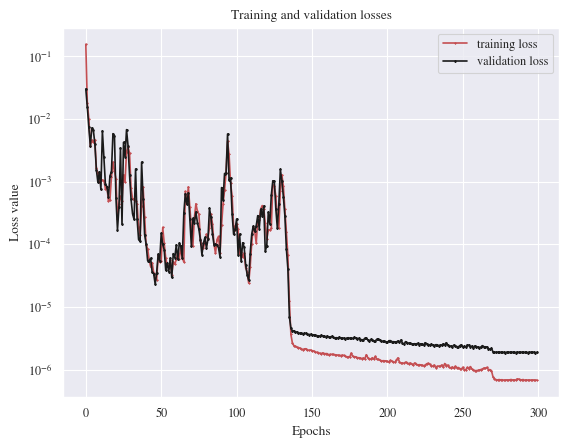

[I 2024-04-25 18:43:34,674] Trial 18 finished with value: 1.8788676637060043e-06 and parameters: {'n_layers': 3, 'hidden_nodes': 635, 'gamma': 0.005806738136936779}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  2.684911351025221e-07
The error on the validation trajectories is: 1.8788676637060043e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 2
    hidden_nodes: 565
    gamma: 0.009930966133035953



The average loss in epoch 1 is  0.17114803889258343
The average loss in epoch 2 is  0.021028979088772427
The average loss in epoch 3 is  0.011130818843164227
The average loss in epoch 4 is  0.006163026343777098
The average loss in epoch 5 is  0.005369506273630329
The average loss in epoch 6 is  0.0039969499021853235
The average loss in epoch 7 is  0.0028246655155354265
The average loss in epoch 8 is  0.0024479980876838617
The average loss in epoch 9 is  0.0017983796979851004
The average loss in epoch 10 is  0.0017003195018994368
The average loss in epoch 11 is  0.0016977530586617913
The average loss in epoch 12 is  0.0011465890949528496
The average loss in epoch 13 is  0.0011891256303484129
The average loss in epoch 14 is  0.0012016405327647756
Th

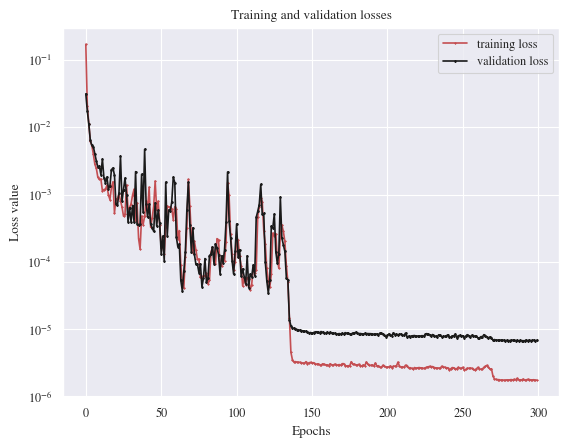

[I 2024-04-25 18:44:42,601] Trial 19 finished with value: 6.840045099709453e-06 and parameters: {'n_layers': 2, 'hidden_nodes': 565, 'gamma': 0.009930966133035953}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  8.177958079613745e-07
The error on the validation trajectories is: 6.840045099709453e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 661
    gamma: 0.0071398902958851925



The average loss in epoch 1 is  0.16345800273120403
The average loss in epoch 2 is  0.01771681916645982
The average loss in epoch 3 is  0.014859570867635986
The average loss in epoch 4 is  0.010150427316230807
The average loss in epoch 5 is  0.005177216212773187
The average loss in epoch 6 is  0.008382407387464562
The average loss in epoch 7 is  0.006136704638431018
The average loss in epoch 8 is  0.0044242692423391745
The average loss in epoch 9 is  0.002818050315413116
The average loss in epoch 10 is  0.001715673944669437
The average loss in epoch 11 is  0.0015096265229989183
The average loss in epoch 12 is  0.0006736348196599548
The average loss in epoch 13 is  0.0003631065357529389
The average loss in epoch 14 is  0.0007106825303873683
The ave

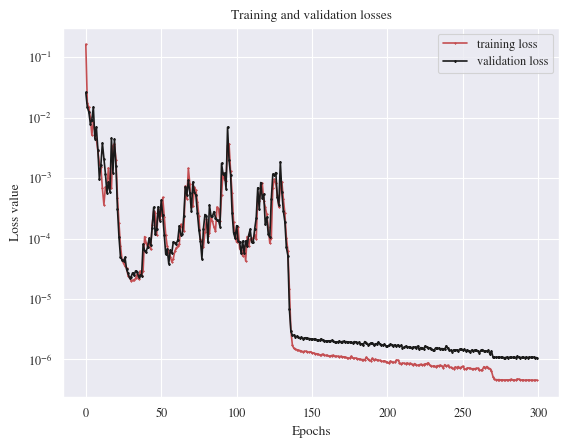

[I 2024-04-25 18:47:09,804] Trial 20 finished with value: 1.0706720099855669e-06 and parameters: {'n_layers': 4, 'hidden_nodes': 661, 'gamma': 0.0071398902958851925}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  2.0134470446464547e-07
The error on the validation trajectories is: 1.0706720099855669e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 576
    gamma: 0.008030469917595507



The average loss in epoch 1 is  0.16940255056728015
The average loss in epoch 2 is  0.01825108031996272
The average loss in epoch 3 is  0.014065421906045893
The average loss in epoch 4 is  0.01006118551065976
The average loss in epoch 5 is  0.005688922151669182
The average loss in epoch 6 is  0.006975136803124438
The average loss in epoch 7 is  0.004719780699815601
The average loss in epoch 8 is  0.002309918774037876
The average loss in epoch 9 is  0.0021346509906420993
The average loss in epoch 10 is  0.0016881331856976349
The average loss in epoch 11 is  0.000748917916842567
The average loss in epoch 12 is  0.00030393037278289824
The average loss in epoch 13 is  0.0025496775954459076
The average loss in epoch 14 is  0.0020827779914146627
The av

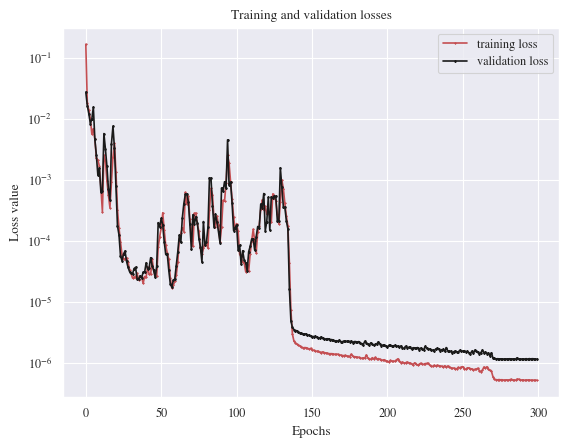

[I 2024-04-25 18:48:55,829] Trial 21 finished with value: 1.141440534153629e-06 and parameters: {'n_layers': 4, 'hidden_nodes': 576, 'gamma': 0.008030469917595507}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  2.12820722822471e-07
The error on the validation trajectories is: 1.141440534153629e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 546
    gamma: 0.008494342524298199



The average loss in epoch 1 is  0.17651484949006277
The average loss in epoch 2 is  0.018365368458696386
The average loss in epoch 3 is  0.01423939706926996
The average loss in epoch 4 is  0.010062338805503467
The average loss in epoch 5 is  0.0062165169616822495
The average loss in epoch 6 is  0.006671995988158001
The average loss in epoch 7 is  0.004800717954904857
The average loss in epoch 8 is  0.002524738530734215
The average loss in epoch 9 is  0.0015526753043311394
The average loss in epoch 10 is  0.001487119241739327
The average loss in epoch 11 is  0.001867916270963509
The average loss in epoch 12 is  0.0004945316964453509
The average loss in epoch 13 is  0.0004687467881012708
The average loss in epoch 14 is  0.0002960900141757024
The avera

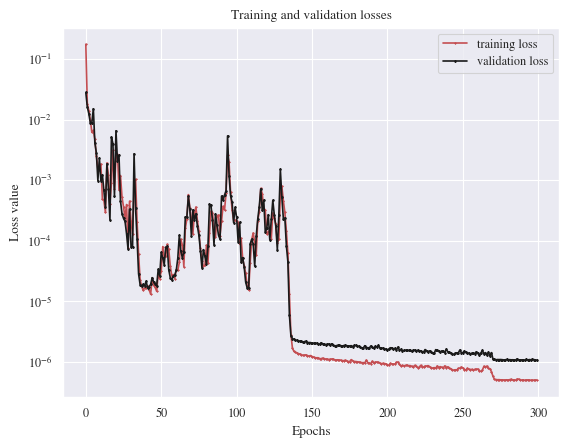

[I 2024-04-25 18:50:43,321] Trial 22 finished with value: 1.0731004725201108e-06 and parameters: {'n_layers': 4, 'hidden_nodes': 546, 'gamma': 0.008494342524298199}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  2.3705622709258023e-07
The error on the validation trajectories is: 1.0731004725201108e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 3
    hidden_nodes: 503
    gamma: 0.007553971067131487



The average loss in epoch 1 is  0.18586297511038455
The average loss in epoch 2 is  0.020667203871363945
The average loss in epoch 3 is  0.012874578654935414
The average loss in epoch 4 is  0.008034425099718977
The average loss in epoch 5 is  0.005410463147034699
The average loss in epoch 6 is  0.004689216963015497
The average loss in epoch 7 is  0.003500347724184394
The average loss in epoch 8 is  0.0015261845811354842
The average loss in epoch 9 is  0.0014105158003406939
The average loss in epoch 10 is  0.0011483054668960076
The average loss in epoch 11 is  0.0012202473272654142
The average loss in epoch 12 is  0.0009480776894964616
The average loss in epoch 13 is  0.001147153464526954
The average loss in epoch 14 is  0.0015856060761672613
The 

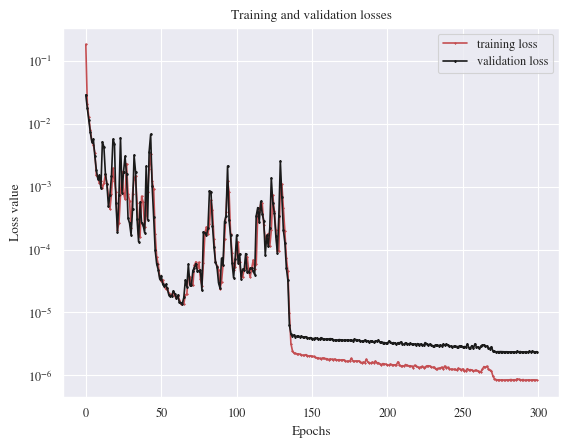

[I 2024-04-25 18:52:24,041] Trial 23 finished with value: 2.3771834231111028e-06 and parameters: {'n_layers': 3, 'hidden_nodes': 503, 'gamma': 0.007553971067131487}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  4.030217723993701e-07
The error on the validation trajectories is: 2.3771834231111028e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 586
    gamma: 0.006676363465605102



The average loss in epoch 1 is  0.17393036161295392
The average loss in epoch 2 is  0.018498245330358095
The average loss in epoch 3 is  0.014610744377767498
The average loss in epoch 4 is  0.01046814490109682
The average loss in epoch 5 is  0.005907121738842266
The average loss in epoch 6 is  0.006948210224932568
The average loss in epoch 7 is  0.004735835266976871
The average loss in epoch 8 is  0.002574724092317576
The average loss in epoch 9 is  0.001648783031586473
The average loss in epoch 10 is  0.0008169964659662747
The average loss in epoch 11 is  0.0007950174033546566
The average loss in epoch 12 is  0.0005209103851071136
The average loss in epoch 13 is  0.0008458664081196978
The average loss in epoch 14 is  0.0002616555198487318
The ave

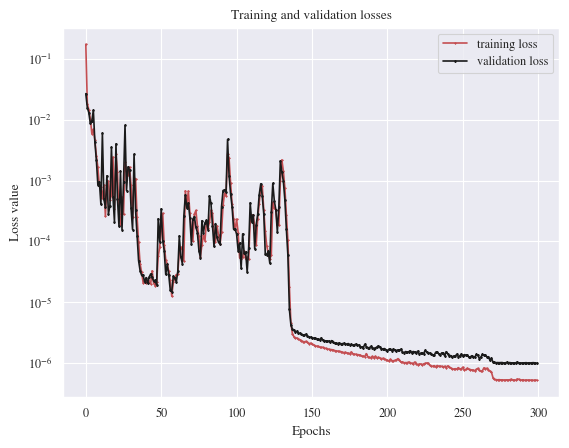

[I 2024-04-25 18:54:16,724] Trial 24 finished with value: 9.912760284167883e-07 and parameters: {'n_layers': 4, 'hidden_nodes': 586, 'gamma': 0.006676363465605102}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  2.373221406060111e-07
The error on the validation trajectories is: 9.912760284167883e-07.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 3
    hidden_nodes: 643
    gamma: 0.0067506339360437605



The average loss in epoch 1 is  0.163052423433824
The average loss in epoch 2 is  0.018085539848967033
The average loss in epoch 3 is  0.010496903528374705
The average loss in epoch 4 is  0.003952086490409618
The average loss in epoch 5 is  0.0048083770406347785
The average loss in epoch 6 is  0.004326822992879897
The average loss in epoch 7 is  0.004383348918054253
The average loss in epoch 8 is  0.0014733759797474538
The average loss in epoch 9 is  0.0012899809543424371
The average loss in epoch 10 is  0.0009730468128426847
The average loss in epoch 11 is  0.001078549039613625
The average loss in epoch 12 is  0.0012848198966821656
The average loss in epoch 13 is  0.0011060103616645474
The average loss in epoch 14 is  0.0008949398014175875
The av

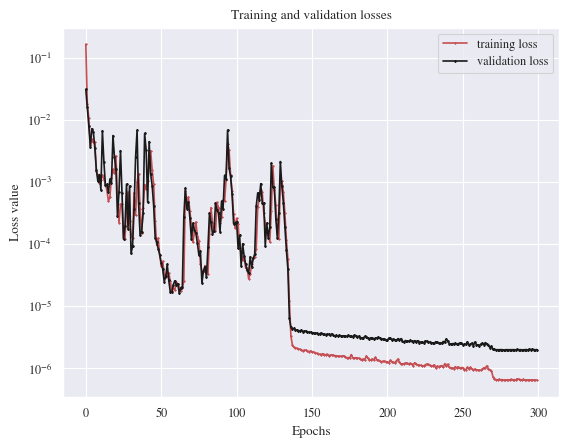

[I 2024-04-25 18:56:16,238] Trial 25 finished with value: 1.9914687117947257e-06 and parameters: {'n_layers': 3, 'hidden_nodes': 643, 'gamma': 0.0067506339360437605}. Best is trial 2 with value: 9.587129491163915e-07.


Loss  2.673279482223734e-07
The error on the validation trajectories is: 1.9914687117947257e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 730
    gamma: 0.005434872088829836



The average loss in epoch 1 is  0.15643721023066479
The average loss in epoch 2 is  0.017025649378245526
The average loss in epoch 3 is  0.014601056887344881
The average loss in epoch 4 is  0.007737084090794352
The average loss in epoch 5 is  0.005784286175515841
The average loss in epoch 6 is  0.004028636306016283
The average loss in epoch 7 is  0.004001703176816756
The average loss in epoch 8 is  0.0013161863263865764
The average loss in epoch 9 is  0.001448483399475332
The average loss in epoch 10 is  0.0012446447653928772
The average loss in epoch 11 is  0.0014707694301085378
The average loss in epoch 12 is  0.0007912203185366128
The average loss in epoch 13 is  0.0009277009190885689
The average loss in epoch 14 is  0.00037900123425060883
The 

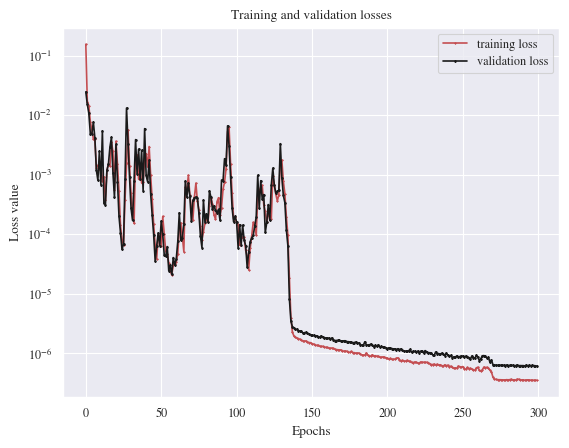

[I 2024-04-25 18:59:10,482] Trial 26 finished with value: 6.044653604098181e-07 and parameters: {'n_layers': 4, 'hidden_nodes': 730, 'gamma': 0.005434872088829836}. Best is trial 26 with value: 6.044653604098181e-07.


Loss  1.8061105322431104e-07
The error on the validation trajectories is: 6.044653604098181e-07.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 3
    hidden_nodes: 746
    gamma: 0.005030330169864133



The average loss in epoch 1 is  0.14795589633286
The average loss in epoch 2 is  0.016512210692533037
The average loss in epoch 3 is  0.008438974629494955
The average loss in epoch 4 is  0.0032116604085207323
The average loss in epoch 5 is  0.005568280583247542
The average loss in epoch 6 is  0.004283429903973063
The average loss in epoch 7 is  0.0048230684690431435
The average loss in epoch 8 is  0.0015001198679039424
The average loss in epoch 9 is  0.0013554064313542437
The average loss in epoch 10 is  0.0009029327358637767
The average loss in epoch 11 is  0.0009647644110373221
The average loss in epoch 12 is  0.0014850161744768477
The average loss in epoch 13 is  0.0006777076004337604
The average loss in epoch 14 is  0.0007982389982895587
The a

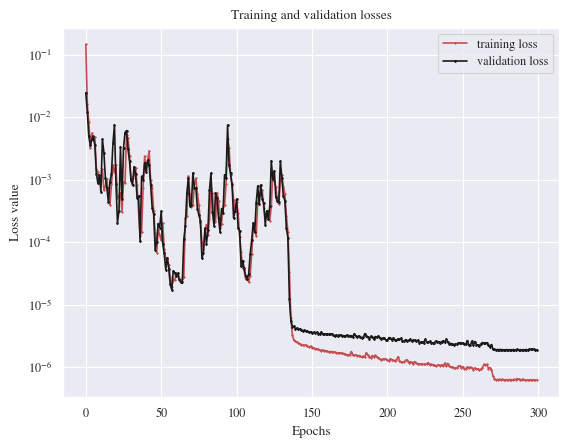

[I 2024-04-25 19:01:29,785] Trial 27 finished with value: 1.8966886522918665e-06 and parameters: {'n_layers': 3, 'hidden_nodes': 746, 'gamma': 0.005030330169864133}. Best is trial 26 with value: 6.044653604098181e-07.


Loss  2.35514988844443e-07
The error on the validation trajectories is: 1.8966886522918665e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 0
    hidden_nodes: 794
    gamma: 0.00616393191831395



The average loss in epoch 1 is  0.2130728675560518
The average loss in epoch 2 is  0.028567977418953724
The average loss in epoch 3 is  0.016304756853390823
The average loss in epoch 4 is  0.013794239906763489
The average loss in epoch 5 is  0.013806363292546435
The average loss in epoch 6 is  0.012874755521558902
The average loss in epoch 7 is  0.0121779570737007
The average loss in epoch 8 is  0.011060530721971934
The average loss in epoch 9 is  0.010181203992529348
The average loss in epoch 10 is  0.009870071133429354
The average loss in epoch 11 is  0.010250836674293334
The average loss in epoch 12 is  0.009577877438542519
The average loss in epoch 13 is  0.00923952820118178
The average loss in epoch 14 is  0.008674063529311256
The average loss 

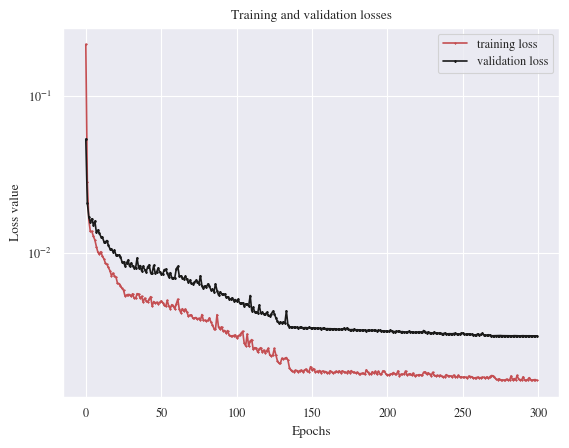

[I 2024-04-25 19:01:56,793] Trial 28 finished with value: 0.0029928754688142915 and parameters: {'n_layers': 0, 'hidden_nodes': 794, 'gamma': 0.00616393191831395}. Best is trial 26 with value: 6.044653604098181e-07.


Loss  0.00042955487151630223
The error on the validation trajectories is: 0.0029928754688142915.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 711
    gamma: 0.009284930151397273



The average loss in epoch 1 is  0.15407859457826073
The average loss in epoch 2 is  0.01685438614169305
The average loss in epoch 3 is  0.012831475479866971
The average loss in epoch 4 is  0.005623547280926935
The average loss in epoch 5 is  0.0052215705985542045
The average loss in epoch 6 is  0.003402360463620756
The average loss in epoch 7 is  0.005602109304163605
The average loss in epoch 8 is  0.0028499186446424574
The average loss in epoch 9 is  0.001713256330483339
The average loss in epoch 10 is  0.0013237325633368032
The average loss in epoch 11 is  0.0019256787120618603
The average loss in epoch 12 is  0.0004710390527510423
The average loss in epoch 13 is  0.0006893911730995486
The average loss in epoch 14 is  0.0007463331206632905
The a

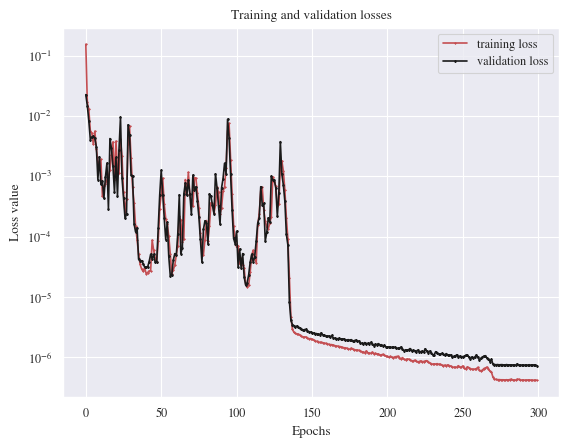

[I 2024-04-25 19:04:28,493] Trial 29 finished with value: 7.343339473657728e-07 and parameters: {'n_layers': 4, 'hidden_nodes': 711, 'gamma': 0.009284930151397273}. Best is trial 26 with value: 6.044653604098181e-07.


Loss  2.1241073966393742e-07
The error on the validation trajectories is: 7.343339473657728e-07.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 2
    hidden_nodes: 702
    gamma: 0.009129269700654094



The average loss in epoch 1 is  0.15586888205937363
The average loss in epoch 2 is  0.01826174163513563
The average loss in epoch 3 is  0.009063440999439494
The average loss in epoch 4 is  0.004504631596236405
The average loss in epoch 5 is  0.004357785827861252
The average loss in epoch 6 is  0.004719537248919633
The average loss in epoch 7 is  0.00344938971366818
The average loss in epoch 8 is  0.0020576374531215565
The average loss in epoch 9 is  0.0016553401708899235
The average loss in epoch 10 is  0.0014800859551707451
The average loss in epoch 11 is  0.001509765768952837
The average loss in epoch 12 is  0.0009438953804254362
The average loss in epoch 13 is  0.000905797406713563
The average loss in epoch 14 is  0.0012116067194834943
The aver

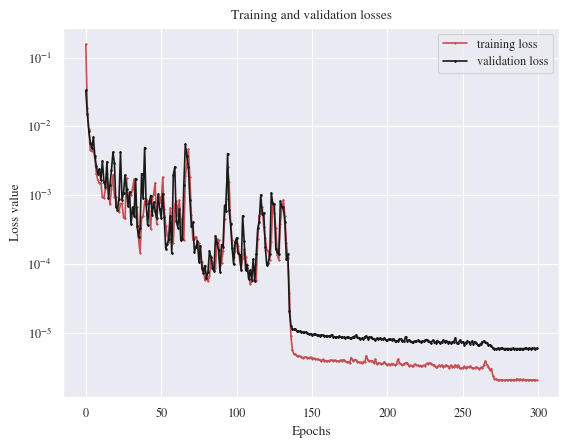

[I 2024-04-25 19:06:10,949] Trial 30 finished with value: 5.931617557462569e-06 and parameters: {'n_layers': 2, 'hidden_nodes': 702, 'gamma': 0.009129269700654094}. Best is trial 26 with value: 6.044653604098181e-07.


Loss  6.946875146240927e-07
The error on the validation trajectories is: 5.931617557462569e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 728
    gamma: 0.009079404782240908



The average loss in epoch 1 is  0.15718694996427407
The average loss in epoch 2 is  0.017592488788068295
The average loss in epoch 3 is  0.013882806143638763
The average loss in epoch 4 is  0.007358777453191578
The average loss in epoch 5 is  0.00925683595282449
The average loss in epoch 6 is  0.006685666443610733
The average loss in epoch 7 is  0.0032255216025408695
The average loss in epoch 8 is  0.0020927547276104715
The average loss in epoch 9 is  0.0015609597308370708
The average loss in epoch 10 is  0.0016930743758249182
The average loss in epoch 11 is  0.001262772737060335
The average loss in epoch 12 is  0.0004830996053483845
The average loss in epoch 13 is  0.00029971173584768127
The average loss in epoch 14 is  0.0017419406685803551
The a

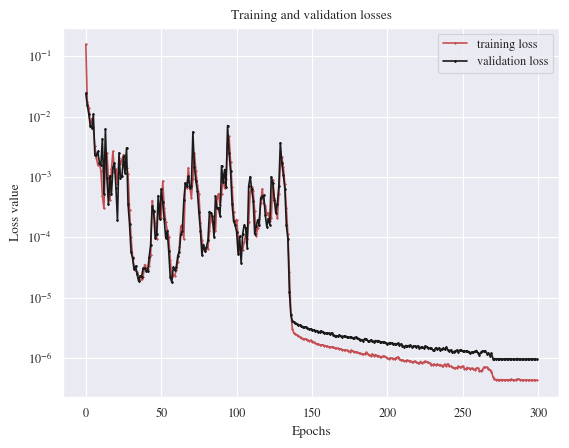

[I 2024-04-25 19:08:35,296] Trial 31 finished with value: 9.411245079271992e-07 and parameters: {'n_layers': 4, 'hidden_nodes': 728, 'gamma': 0.009079404782240908}. Best is trial 26 with value: 6.044653604098181e-07.


Loss  2.1342894740428164e-07
The error on the validation trajectories is: 9.411245079271992e-07.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 718
    gamma: 0.00918113244147585



The average loss in epoch 1 is  0.15784935390746052
The average loss in epoch 2 is  0.017143253999000244
The average loss in epoch 3 is  0.014070684640583668
The average loss in epoch 4 is  0.007120894342237575
The average loss in epoch 5 is  0.005677547834982926
The average loss in epoch 6 is  0.0033396689290053805
The average loss in epoch 7 is  0.005792974901851267
The average loss in epoch 8 is  0.0029784406572368675
The average loss in epoch 9 is  0.0016078634931049733
The average loss in epoch 10 is  0.0007816057623131201
The average loss in epoch 11 is  0.0006905528749815527
The average loss in epoch 12 is  0.0002819225132539445
The average loss in epoch 13 is  0.0023509677372534166
The average loss in epoch 14 is  0.0017280198490797457
The 

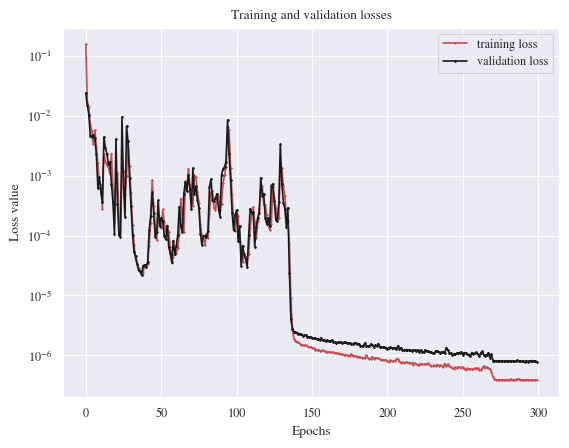

[I 2024-04-25 19:10:56,360] Trial 32 finished with value: 7.768019669932172e-07 and parameters: {'n_layers': 4, 'hidden_nodes': 718, 'gamma': 0.00918113244147585}. Best is trial 26 with value: 6.044653604098181e-07.


Loss  1.5941643027872487e-07
The error on the validation trajectories is: 7.768019669932172e-07.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 725
    gamma: 0.00922911787703993



The average loss in epoch 1 is  0.1562127252532677
The average loss in epoch 2 is  0.017465720715170555
The average loss in epoch 3 is  0.01439574005251581
The average loss in epoch 4 is  0.006462591515049677
The average loss in epoch 5 is  0.006738397536206652
The average loss in epoch 6 is  0.005366757035848092
The average loss in epoch 7 is  0.004304676480718295
The average loss in epoch 8 is  0.0025679306232963095
The average loss in epoch 9 is  0.0014318130759585818
The average loss in epoch 10 is  0.0008079933388878337
The average loss in epoch 11 is  0.00086513224034041
The average loss in epoch 12 is  0.0007099719051356343
The average loss in epoch 13 is  0.0007208235534066757
The average loss in epoch 14 is  0.0001918760253002719
The avera

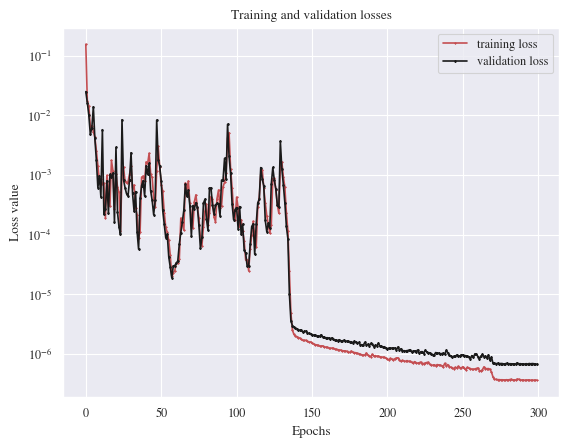

[I 2024-04-25 19:13:16,777] Trial 33 finished with value: 6.618257266143881e-07 and parameters: {'n_layers': 4, 'hidden_nodes': 725, 'gamma': 0.00922911787703993}. Best is trial 26 with value: 6.044653604098181e-07.


Loss  1.6322971418958332e-07
The error on the validation trajectories is: 6.618257266143881e-07.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 782
    gamma: 0.00953558751760893



The average loss in epoch 1 is  0.1492529810321602
The average loss in epoch 2 is  0.016476670576428824
The average loss in epoch 3 is  0.010517343476584012
The average loss in epoch 4 is  0.003958924191961573
The average loss in epoch 5 is  0.004473808914719319
The average loss in epoch 6 is  0.0029857217979786747
The average loss in epoch 7 is  0.0044800876031248745
The average loss in epoch 8 is  0.0016230970782502977
The average loss in epoch 9 is  0.0005093703862671232
The average loss in epoch 10 is  0.0013439321367265868
The average loss in epoch 11 is  0.0018992899276781827
The average loss in epoch 12 is  0.0007642357615457678
The average loss in epoch 13 is  0.001125661465762691
The average loss in epoch 14 is  0.00031481653356670654
The 

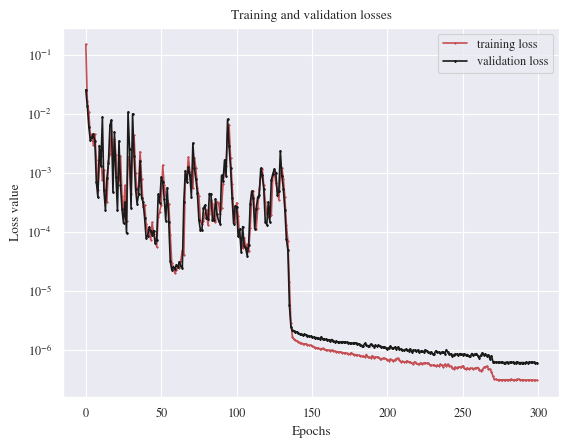

[I 2024-04-25 19:16:08,297] Trial 34 finished with value: 5.962329976981219e-07 and parameters: {'n_layers': 4, 'hidden_nodes': 782, 'gamma': 0.00953558751760893}. Best is trial 34 with value: 5.962329976981219e-07.


Loss  1.358856422939425e-07
The error on the validation trajectories is: 5.962329976981219e-07.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 3
    hidden_nodes: 773
    gamma: 0.00844105472395406



The average loss in epoch 1 is  0.15171565919775853
The average loss in epoch 2 is  0.015935676426372745
The average loss in epoch 3 is  0.0082276974783533
The average loss in epoch 4 is  0.0032322152401320636
The average loss in epoch 5 is  0.004591129132842814
The average loss in epoch 6 is  0.0038846774577078495
The average loss in epoch 7 is  0.004710865318140184
The average loss in epoch 8 is  0.0014593834163282406
The average loss in epoch 9 is  0.0013815895019268448
The average loss in epoch 10 is  0.0008839057839147492
The average loss in epoch 11 is  0.000975439219142903
The average loss in epoch 12 is  0.0015899818165714598
The average loss in epoch 13 is  0.000749529551698784
The average loss in epoch 14 is  0.0009874683693686331
The aver

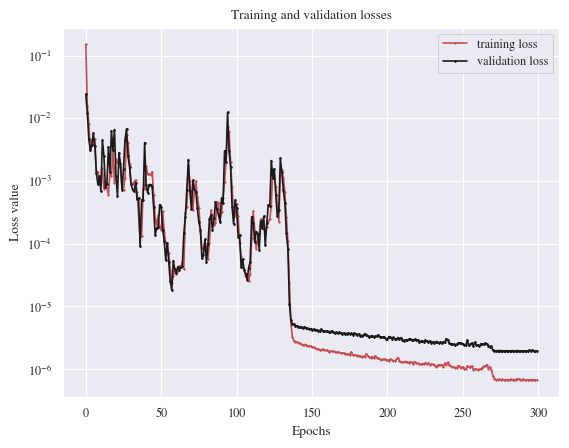

[I 2024-04-25 19:18:32,275] Trial 35 finished with value: 1.9553184404850815e-06 and parameters: {'n_layers': 3, 'hidden_nodes': 773, 'gamma': 0.00844105472395406}. Best is trial 34 with value: 5.962329976981219e-07.


Loss  2.9012494451308157e-07
The error on the validation trajectories is: 1.9553184404850815e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 832
    gamma: 0.00963472504575368



The average loss in epoch 1 is  0.1501626241952181
The average loss in epoch 2 is  0.016522418961606243
The average loss in epoch 3 is  0.011175749759951776
The average loss in epoch 4 is  0.005514260900037532
The average loss in epoch 5 is  0.0042078628374094314
The average loss in epoch 6 is  0.0036843795149417765
The average loss in epoch 7 is  0.006657210295088589
The average loss in epoch 8 is  0.003968817250676115
The average loss in epoch 9 is  0.002250076533528045
The average loss in epoch 10 is  0.0018268031417392194
The average loss in epoch 11 is  0.0013677177246956323
The average loss in epoch 12 is  0.00036763929462970486
The average loss in epoch 13 is  0.000591464967411329
The average loss in epoch 14 is  0.00033098712711679667
The 

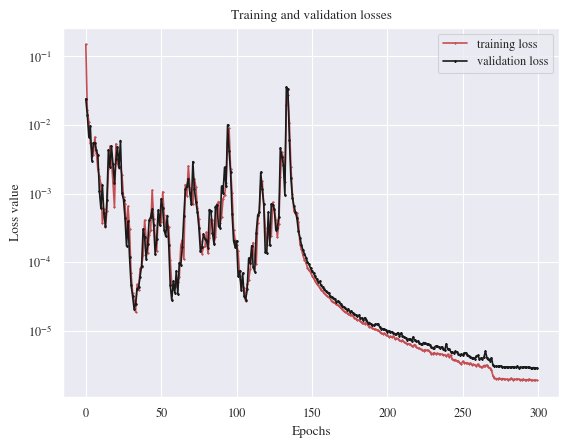

[I 2024-04-25 19:21:44,703] Trial 36 finished with value: 2.874232395461435e-06 and parameters: {'n_layers': 4, 'hidden_nodes': 832, 'gamma': 0.00963472504575368}. Best is trial 34 with value: 5.962329976981219e-07.


Loss  7.708865723543568e-07
The error on the validation trajectories is: 2.874232395461435e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 3
    hidden_nodes: 767
    gamma: 0.009544630325477825



The average loss in epoch 1 is  0.1521318397400054
The average loss in epoch 2 is  0.01651629407636144
The average loss in epoch 3 is  0.008627921321683309
The average loss in epoch 4 is  0.003325802506878972
The average loss in epoch 5 is  0.0052942458053373475
The average loss in epoch 6 is  0.004064810790375553
The average loss in epoch 7 is  0.005019931329033253
The average loss in epoch 8 is  0.0016012916722419586
The average loss in epoch 9 is  0.0013486065052513202
The average loss in epoch 10 is  0.0009552944704244675
The average loss in epoch 11 is  0.0009476738473908467
The average loss in epoch 12 is  0.0014995635283412412
The average loss in epoch 13 is  0.0010193812816975299
The average loss in epoch 14 is  0.0024288386398852294
The av

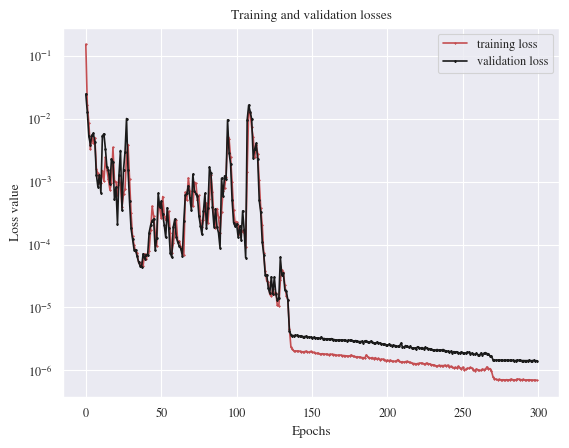

[I 2024-04-25 19:24:02,850] Trial 37 finished with value: 1.4264940209132622e-06 and parameters: {'n_layers': 3, 'hidden_nodes': 767, 'gamma': 0.009544630325477825}. Best is trial 34 with value: 5.962329976981219e-07.


Loss  3.711374745307694e-07
The error on the validation trajectories is: 1.4264940209132622e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 910
    gamma: 0.00878782398879601



The average loss in epoch 1 is  0.14073304230855269
The average loss in epoch 2 is  0.012908498227426951
The average loss in epoch 3 is  0.006643022812733596
The average loss in epoch 4 is  0.005847088331144981
The average loss in epoch 5 is  0.004063382099213248
The average loss in epoch 6 is  0.0029895991213958373
The average loss in epoch 7 is  0.006398324214387685
The average loss in epoch 8 is  0.0027161056323992934
The average loss in epoch 9 is  0.0010551332591355524
The average loss in epoch 10 is  0.0013362117037600415
The average loss in epoch 11 is  0.0024485103415579283
The average loss in epoch 12 is  0.0008061672507954592
The average loss in epoch 13 is  0.0007484928937628865
The average loss in epoch 14 is  0.0010183619881652041
The 

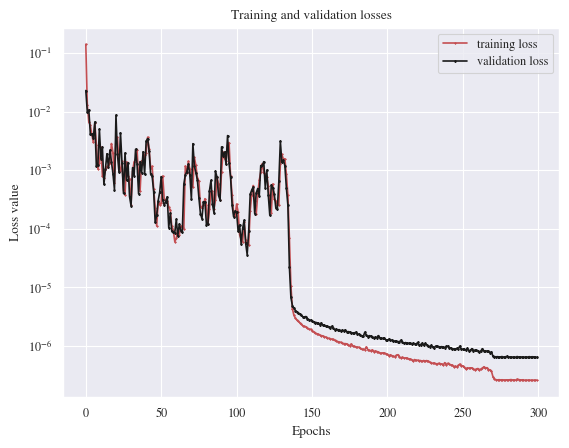

[I 2024-04-25 19:27:37,390] Trial 38 finished with value: 6.404064326922536e-07 and parameters: {'n_layers': 4, 'hidden_nodes': 910, 'gamma': 0.00878782398879601}. Best is trial 34 with value: 5.962329976981219e-07.


Loss  1.280710790751982e-07
The error on the validation trajectories is: 6.404064326922536e-07.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 1
    hidden_nodes: 949
    gamma: 0.008227855564748202



The average loss in epoch 1 is  0.14383262903852898
The average loss in epoch 2 is  0.019244973463090984
The average loss in epoch 3 is  0.00914132872342386
The average loss in epoch 4 is  0.0058918272737752304
The average loss in epoch 5 is  0.00571673079287972
The average loss in epoch 6 is  0.005883688890290531
The average loss in epoch 7 is  0.003301107017746703
The average loss in epoch 8 is  0.003509380410171368
The average loss in epoch 9 is  0.0024639189703686334
The average loss in epoch 10 is  0.002046571642329747
The average loss in epoch 11 is  0.0019480880371040919
The average loss in epoch 12 is  0.0019145180069079454
The average loss in epoch 13 is  0.001834116254361685
The average loss in epoch 14 is  0.0013788366116138852
The avera

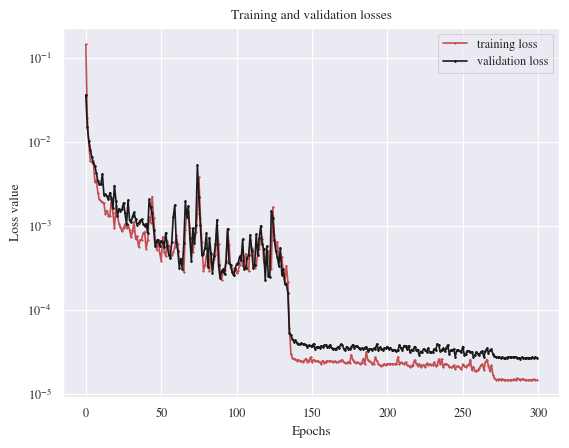

[I 2024-04-25 19:29:14,678] Trial 39 finished with value: 2.679650251770061e-05 and parameters: {'n_layers': 1, 'hidden_nodes': 949, 'gamma': 0.008227855564748202}. Best is trial 34 with value: 5.962329976981219e-07.


Loss  4.557485226541758e-06
The error on the validation trajectories is: 2.679650251770061e-05.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 3
    hidden_nodes: 915
    gamma: 0.008672820466460951



The average loss in epoch 1 is  0.13921357386491515
The average loss in epoch 2 is  0.01315184468826787
The average loss in epoch 3 is  0.007578681847503917
The average loss in epoch 4 is  0.003923454766415737
The average loss in epoch 5 is  0.005198346519715746
The average loss in epoch 6 is  0.004191402213605629
The average loss in epoch 7 is  0.0038327932124957442
The average loss in epoch 8 is  0.0012560488645580006
The average loss in epoch 9 is  0.0014592487118947743
The average loss in epoch 10 is  0.0008828327984453856
The average loss in epoch 11 is  0.0011978178822160276
The average loss in epoch 12 is  0.0028996526856314053
The average loss in epoch 13 is  0.0013358462205029684
The average loss in epoch 14 is  0.0008453536383140917
The a

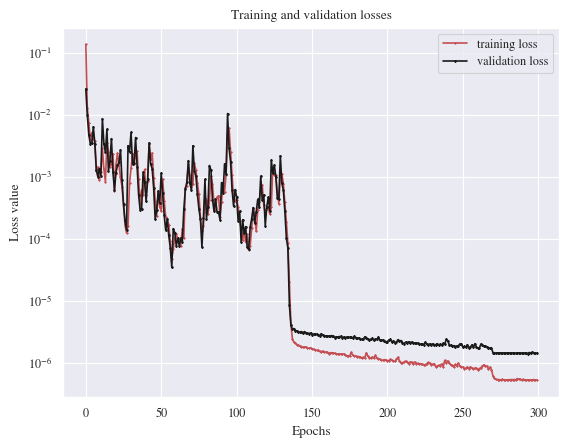

[I 2024-04-25 19:32:25,471] Trial 40 finished with value: 1.4318892798654601e-06 and parameters: {'n_layers': 3, 'hidden_nodes': 915, 'gamma': 0.008672820466460951}. Best is trial 34 with value: 5.962329976981219e-07.


Loss  1.7363034032769065e-07
The error on the validation trajectories is: 1.4318892798654601e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 827
    gamma: 0.00992564612601416



The average loss in epoch 1 is  0.14591868602755395
The average loss in epoch 2 is  0.015490238470110025
The average loss in epoch 3 is  0.010150516384535214
The average loss in epoch 4 is  0.004684837217527357
The average loss in epoch 5 is  0.006550657689910044
The average loss in epoch 6 is  0.004493752870158377
The average loss in epoch 7 is  0.0036070596754804933
The average loss in epoch 8 is  0.0010671203477117656
The average loss in epoch 9 is  0.0015481368754990399
The average loss in epoch 10 is  0.0006680768022885208
The average loss in epoch 11 is  0.0014281290376939896
The average loss in epoch 12 is  0.0012048104816296307
The average loss in epoch 13 is  0.000902665513091382
The average loss in epoch 14 is  0.0008703217152453197
The 

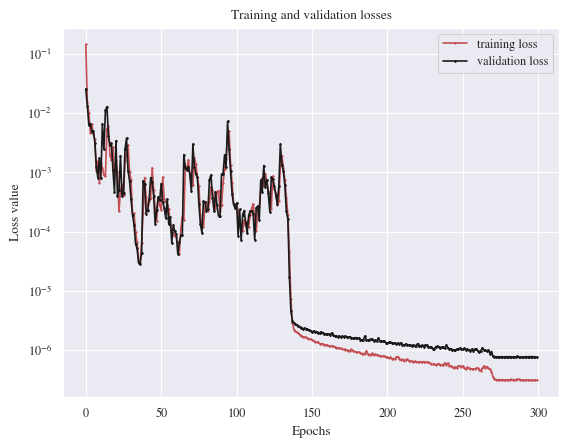

[I 2024-04-25 19:35:25,959] Trial 41 finished with value: 7.519120578902829e-07 and parameters: {'n_layers': 4, 'hidden_nodes': 827, 'gamma': 0.00992564612601416}. Best is trial 34 with value: 5.962329976981219e-07.


Loss  1.4953923255234258e-07
The error on the validation trajectories is: 7.519120578902829e-07.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 869
    gamma: 0.00885643085544894



The average loss in epoch 1 is  0.14459389752962373
The average loss in epoch 2 is  0.01400955906137824
The average loss in epoch 3 is  0.007798748037947173
The average loss in epoch 4 is  0.004562588699627668
The average loss in epoch 5 is  0.0022342483068562365
The average loss in epoch 6 is  0.003072299071143127
The average loss in epoch 7 is  0.0042763117208695885
The average loss in epoch 8 is  0.0018736655633388596
The average loss in epoch 9 is  0.0005827259288211776
The average loss in epoch 10 is  0.0015829353095878932
The average loss in epoch 11 is  0.0025574579961936583
The average loss in epoch 12 is  0.0020208944360175255
The average loss in epoch 13 is  0.0029872221348341554
The average loss in epoch 14 is  0.0020998994930943645
The 

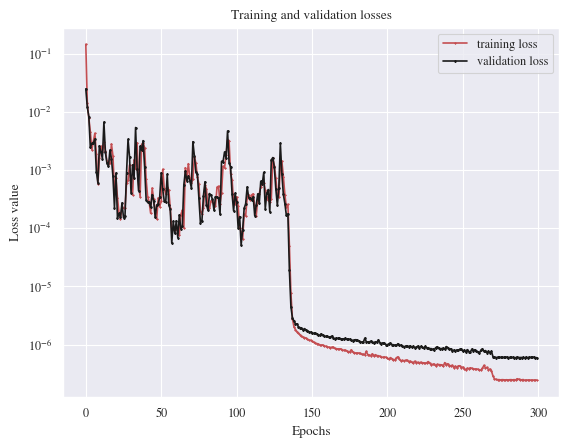

[I 2024-04-25 19:39:22,276] Trial 42 finished with value: 5.958092926830733e-07 and parameters: {'n_layers': 4, 'hidden_nodes': 869, 'gamma': 0.00885643085544894}. Best is trial 42 with value: 5.958092926830733e-07.


Loss  1.021824473923516e-07
The error on the validation trajectories is: 5.958092926830733e-07.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 862
    gamma: 0.008986302005462741



The average loss in epoch 1 is  0.14128199643032116
The average loss in epoch 2 is  0.014289764814417471
The average loss in epoch 3 is  0.0074526021913201975
The average loss in epoch 4 is  0.005391588334036483
The average loss in epoch 5 is  0.0031569545019672
The average loss in epoch 6 is  0.0053306439446962695
The average loss in epoch 7 is  0.006835322996432131
The average loss in epoch 8 is  0.00397463008465076
The average loss in epoch 9 is  0.0012204767077822578
The average loss in epoch 10 is  0.0017138760872926055
The average loss in epoch 11 is  0.001329157640363767
The average loss in epoch 12 is  0.0004732539336228828
The average loss in epoch 13 is  0.0010125999205311846
The average loss in epoch 14 is  0.00020332693384261802
The ave

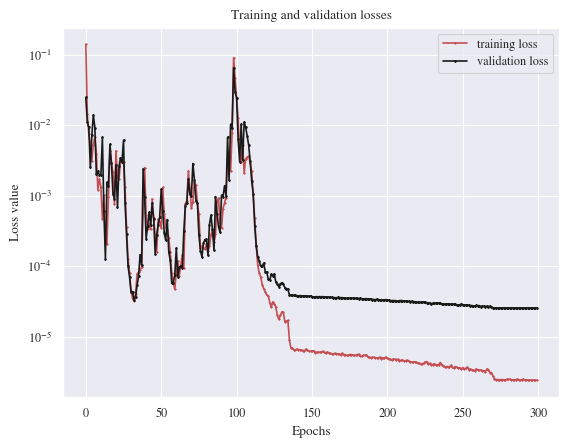

[I 2024-04-25 19:42:48,012] Trial 43 finished with value: 2.5390285670239636e-05 and parameters: {'n_layers': 4, 'hidden_nodes': 862, 'gamma': 0.008986302005462741}. Best is trial 42 with value: 5.958092926830733e-07.


Loss  2.1239800389594166e-06
The error on the validation trajectories is: 2.5390285670239636e-05.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 901
    gamma: 0.008196722191829518



The average loss in epoch 1 is  0.1478884250602939
The average loss in epoch 2 is  0.014267932496626268
The average loss in epoch 3 is  0.007850302499718964
The average loss in epoch 4 is  0.005206572828518058
The average loss in epoch 5 is  0.002261830398558893
The average loss in epoch 6 is  0.0034188213731712576
The average loss in epoch 7 is  0.005262302615764466
The average loss in epoch 8 is  0.0018212447281588209
The average loss in epoch 9 is  0.0017188965866807848
The average loss in epoch 10 is  0.0008287989992161536
The average loss in epoch 11 is  0.0005895036315037446
The average loss in epoch 12 is  0.0004103266685640185
The average loss in epoch 13 is  0.003923412419680972
The average loss in epoch 14 is  0.0036825675289781593
The 

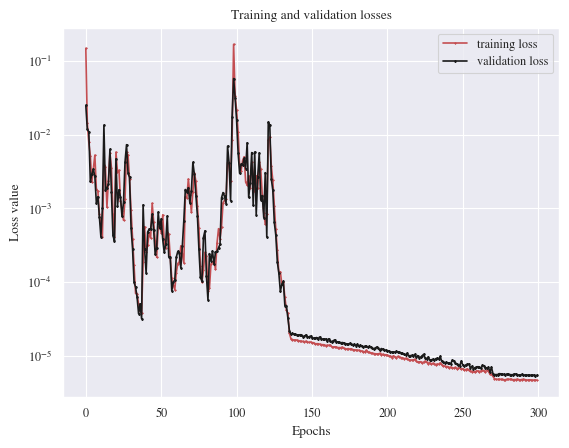

[I 2024-04-25 19:46:34,933] Trial 44 finished with value: 5.4545439426170495e-06 and parameters: {'n_layers': 4, 'hidden_nodes': 901, 'gamma': 0.008196722191829518}. Best is trial 42 with value: 5.958092926830733e-07.


Loss  4.0723934944253415e-06
The error on the validation trajectories is: 5.4545439426170495e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 932
    gamma: 0.00883868653735616



The average loss in epoch 1 is  0.1436775792390108
The average loss in epoch 2 is  0.013167016398669644
The average loss in epoch 3 is  0.006553259699351408
The average loss in epoch 4 is  0.0029300699772482567
The average loss in epoch 5 is  0.006458174442576075
The average loss in epoch 6 is  0.005677065515721386
The average loss in epoch 7 is  0.0029508913496763193
The average loss in epoch 8 is  0.0009847829695156013
The average loss in epoch 9 is  0.0024446995217162607
The average loss in epoch 10 is  0.0033660197910979728
The average loss in epoch 11 is  0.002120991338002072
The average loss in epoch 12 is  0.0005862654043911872
The average loss in epoch 13 is  0.00038029798452043906
The average loss in epoch 14 is  0.0020209021273661742
The

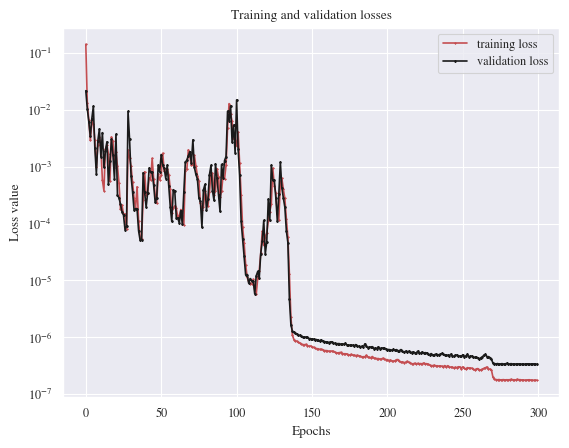

[I 2024-04-25 19:50:34,383] Trial 45 finished with value: 3.3237931721427406e-07 and parameters: {'n_layers': 4, 'hidden_nodes': 932, 'gamma': 0.00883868653735616}. Best is trial 45 with value: 3.3237931721427406e-07.


Loss  1.1208366146320259e-07
The error on the validation trajectories is: 3.3237931721427406e-07.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 0
    hidden_nodes: 963
    gamma: 0.00875944610542011



The average loss in epoch 1 is  0.220599686388265
The average loss in epoch 2 is  0.02829459487375888
The average loss in epoch 3 is  0.01620491399345073
The average loss in epoch 4 is  0.013521427838978443
The average loss in epoch 5 is  0.013590186008844863
The average loss in epoch 6 is  0.01291655717332932
The average loss in epoch 7 is  0.01177505242892287
The average loss in epoch 8 is  0.010557674993337556
The average loss in epoch 9 is  0.009892214216630568
The average loss in epoch 10 is  0.009485012957487594
The average loss in epoch 11 is  0.009837779618630355
The average loss in epoch 12 is  0.00938382829454812
The average loss in epoch 13 is  0.008909359404986555
The average loss in epoch 14 is  0.00860521131703122
The average loss in

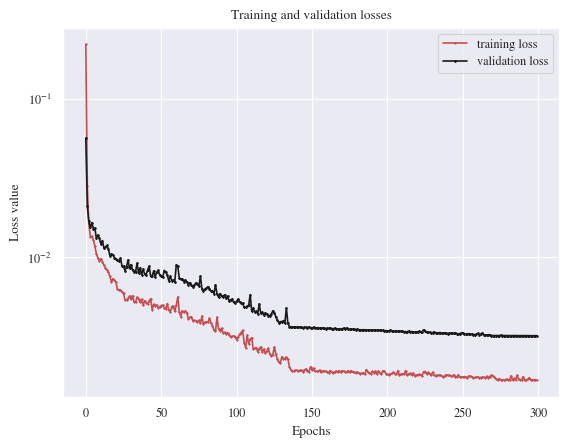

[I 2024-04-25 19:51:13,018] Trial 46 finished with value: 0.0032095702222041766 and parameters: {'n_layers': 0, 'hidden_nodes': 963, 'gamma': 0.00875944610542011}. Best is trial 45 with value: 3.3237931721427406e-07.


Loss  0.0003894309629686177
The error on the validation trajectories is: 0.0032095702222041766.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 3
    hidden_nodes: 873
    gamma: 0.007962211766582659



The average loss in epoch 1 is  0.13991479211571542
The average loss in epoch 2 is  0.015062803656540134
The average loss in epoch 3 is  0.00907708015504547
The average loss in epoch 4 is  0.003922594017984176
The average loss in epoch 5 is  0.004808973378120837
The average loss in epoch 6 is  0.0037384639779867775
The average loss in epoch 7 is  0.004973166680429131
The average loss in epoch 8 is  0.0013775617725596849
The average loss in epoch 9 is  0.0013991798425029795
The average loss in epoch 10 is  0.0008357678968671032
The average loss in epoch 11 is  0.0011039334256731142
The average loss in epoch 12 is  0.0019648263458458878
The average loss in epoch 13 is  0.0007890762572060339
The average loss in epoch 14 is  0.0018919327908819964
The a

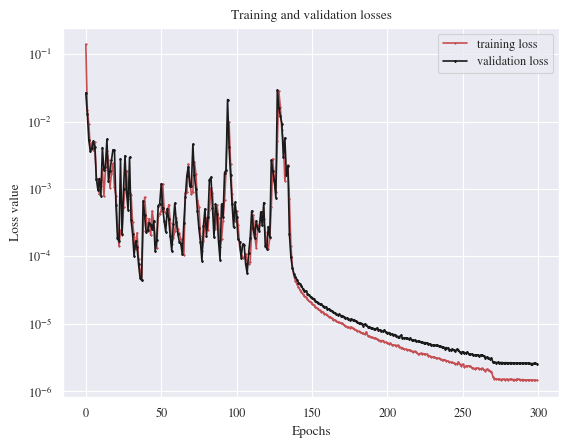

[I 2024-04-25 19:54:06,015] Trial 47 finished with value: 2.5504511638963412e-06 and parameters: {'n_layers': 3, 'hidden_nodes': 873, 'gamma': 0.007962211766582659}. Best is trial 45 with value: 3.3237931721427406e-07.


Loss  9.261888749279024e-07
The error on the validation trajectories is: 2.5504511638963412e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 942
    gamma: 0.009613602073820714



The average loss in epoch 1 is  0.14134825283492153
The average loss in epoch 2 is  0.012917090101506223
The average loss in epoch 3 is  0.006628785388205539
The average loss in epoch 4 is  0.0031271968089806087
The average loss in epoch 5 is  0.005642201730304144
The average loss in epoch 6 is  0.004606858620801094
The average loss in epoch 7 is  0.004396884040695361
The average loss in epoch 8 is  0.0013075315218884498
The average loss in epoch 9 is  0.0018998870483218607
The average loss in epoch 10 is  0.001797513536241075
The average loss in epoch 11 is  0.0021853250509593636
The average loss in epoch 12 is  0.0021106224184305493
The average loss in epoch 13 is  0.0012911036002068695
The average loss in epoch 14 is  0.0003167331815348007
The 

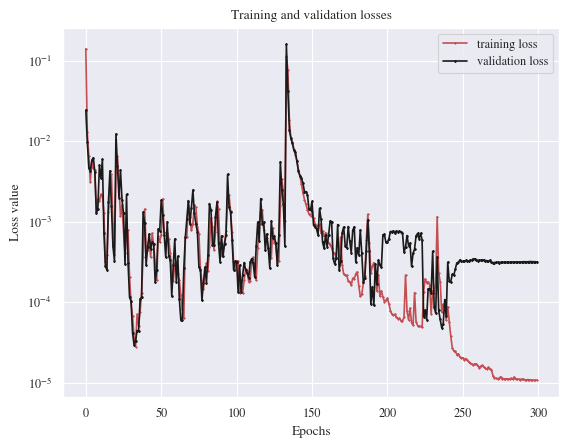

[I 2024-04-25 19:57:58,984] Trial 48 finished with value: 0.0003161792856839016 and parameters: {'n_layers': 4, 'hidden_nodes': 942, 'gamma': 0.009613602073820714}. Best is trial 45 with value: 3.3237931721427406e-07.


Loss  1.0657542588887736e-05
The error on the validation trajectories is: 0.0003161792856839016.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 985
    gamma: 0.008635332336607902



The average loss in epoch 1 is  0.1432907995344563
The average loss in epoch 2 is  0.012983092784204266
The average loss in epoch 3 is  0.0059503215174614025
The average loss in epoch 4 is  0.0028234343229666015
The average loss in epoch 5 is  0.007480346650647169
The average loss in epoch 6 is  0.006078318851491945
The average loss in epoch 7 is  0.007421053443315693
The average loss in epoch 8 is  0.004629335927099667
The average loss in epoch 9 is  0.0014570026952159506
The average loss in epoch 10 is  0.0012831312335699542
The average loss in epoch 11 is  0.0015339962780920112
The average loss in epoch 12 is  0.0005213904746183703
The average loss in epoch 13 is  0.0003889087800582109
The average loss in epoch 14 is  0.001814730563968293
The a

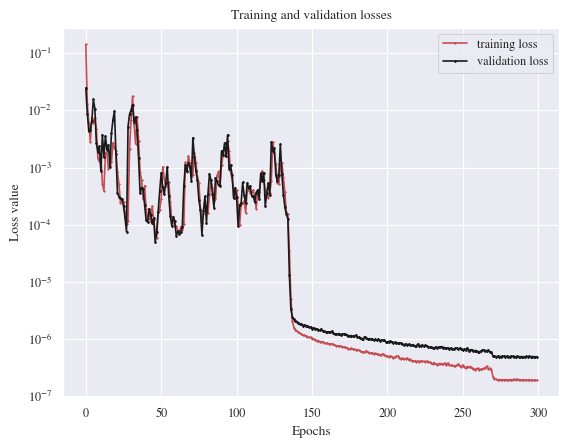

[I 2024-04-25 20:02:32,321] Trial 49 finished with value: 4.863041113474374e-07 and parameters: {'n_layers': 4, 'hidden_nodes': 985, 'gamma': 0.008635332336607902}. Best is trial 45 with value: 3.3237931721427406e-07.


Loss  1.0762320101775913e-07
The error on the validation trajectories is: 4.863041113474374e-07.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 964
    gamma: 0.0073857498196779085



The average loss in epoch 1 is  0.14726121410388837
The average loss in epoch 2 is  0.013891985153102061
The average loss in epoch 3 is  0.005966171474111351
The average loss in epoch 4 is  0.0026296983679375526
The average loss in epoch 5 is  0.006454727593915199
The average loss in epoch 6 is  0.005867072243497453
The average loss in epoch 7 is  0.004633582001340322
The average loss in epoch 8 is  0.0026428924016231163
The average loss in epoch 9 is  0.0015317023313731295
The average loss in epoch 10 is  0.001607207487474873
The average loss in epoch 11 is  0.0022328408376779407
The average loss in epoch 12 is  0.000531655288465448
The average loss in epoch 13 is  0.0011377599386667664
The average loss in epoch 14 is  0.0010621378592490642
The 

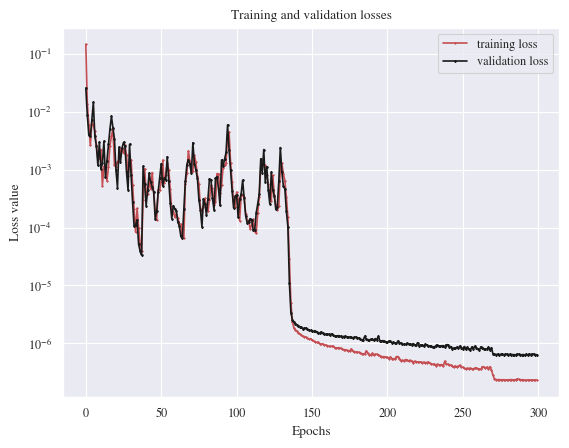

[I 2024-04-25 20:06:33,340] Trial 50 finished with value: 6.332357903481877e-07 and parameters: {'n_layers': 4, 'hidden_nodes': 964, 'gamma': 0.0073857498196779085}. Best is trial 45 with value: 3.3237931721427406e-07.


Loss  9.589990668246173e-08
The error on the validation trajectories is: 6.332357903481877e-07.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 982
    gamma: 0.007371110993262977



The average loss in epoch 1 is  0.14353776071220636
The average loss in epoch 2 is  0.011980354150926525
The average loss in epoch 3 is  0.006237595225684345
The average loss in epoch 4 is  0.003143988390961154
The average loss in epoch 5 is  0.0029741728318516502
The average loss in epoch 6 is  0.006415487907361239
The average loss in epoch 7 is  0.006288193081590262
The average loss in epoch 8 is  0.004546792563897642
The average loss in epoch 9 is  0.002025575705126605
The average loss in epoch 10 is  0.0015456157350193032
The average loss in epoch 11 is  0.0012602545268071647
The average loss in epoch 12 is  0.0007046150448414581
The average loss in epoch 13 is  0.0010060156035416928
The average loss in epoch 14 is  0.0006363828810704449
The av

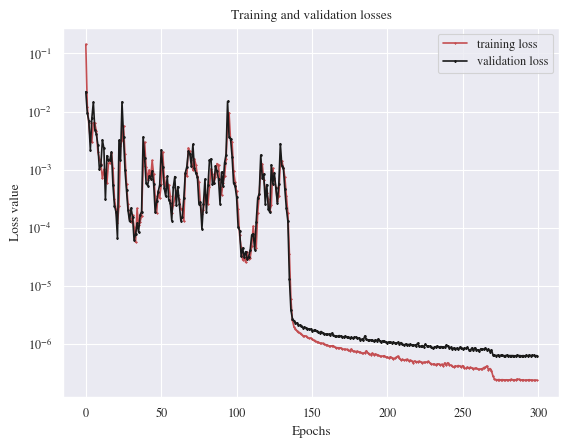

[I 2024-04-25 20:10:44,748] Trial 51 finished with value: 6.228937909877213e-07 and parameters: {'n_layers': 4, 'hidden_nodes': 982, 'gamma': 0.007371110993262977}. Best is trial 45 with value: 3.3237931721427406e-07.


Loss  1.1163594137997279e-07
The error on the validation trajectories is: 6.228937909877213e-07.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 930
    gamma: 0.008204700836506392



The average loss in epoch 1 is  0.13677096011286433
The average loss in epoch 2 is  0.014040591872551224
The average loss in epoch 3 is  0.007134567184204405
The average loss in epoch 4 is  0.003912642084866424
The average loss in epoch 5 is  0.002684073911619965
The average loss in epoch 6 is  0.002845569966170429
The average loss in epoch 7 is  0.004295478569640016
The average loss in epoch 8 is  0.001986588184742934
The average loss in epoch 9 is  0.0011264112161535938
The average loss in epoch 10 is  0.0018822496058419347
The average loss in epoch 11 is  0.002475450159346854
The average loss in epoch 12 is  0.0008108476203315976
The average loss in epoch 13 is  0.0011641876930794256
The average loss in epoch 14 is  0.0011081209641733121
The av

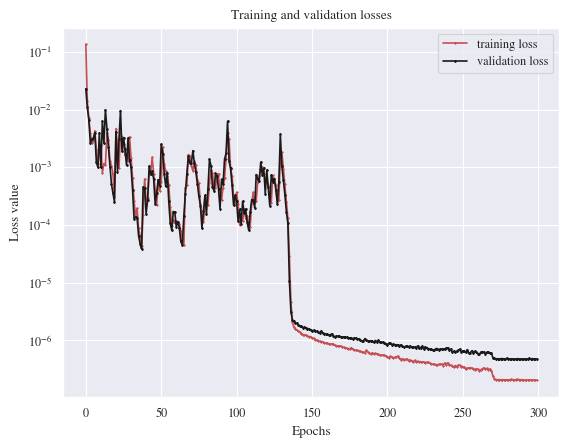

[I 2024-04-25 20:14:31,827] Trial 52 finished with value: 4.70353284979519e-07 and parameters: {'n_layers': 4, 'hidden_nodes': 930, 'gamma': 0.008204700836506392}. Best is trial 45 with value: 3.3237931721427406e-07.


Loss  1.0446274956166235e-07
The error on the validation trajectories is: 4.70353284979519e-07.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 1000
    gamma: 0.008350218499136046



The average loss in epoch 1 is  0.14195803908461874
The average loss in epoch 2 is  0.012866269352591851
The average loss in epoch 3 is  0.006510255456140096
The average loss in epoch 4 is  0.0031006406934466213
The average loss in epoch 5 is  0.0070213200789029625
The average loss in epoch 6 is  0.005467174220195209
The average loss in epoch 7 is  0.003734019002877176
The average loss in epoch 8 is  0.001904274625386196
The average loss in epoch 9 is  0.001482991749071516
The average loss in epoch 10 is  0.0009479257040022111
The average loss in epoch 11 is  0.0007856411208525639
The average loss in epoch 12 is  0.003540304333331402
The average loss in epoch 13 is  0.00343295446311293
The average loss in epoch 14 is  0.004045118456071412
The aver

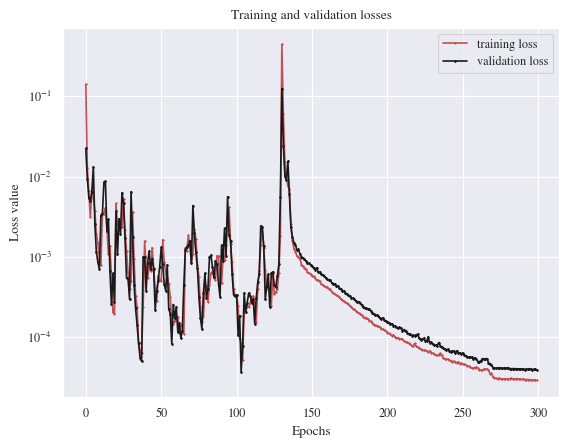

[I 2024-04-25 20:19:04,080] Trial 53 finished with value: 3.8650498086698694e-05 and parameters: {'n_layers': 4, 'hidden_nodes': 1000, 'gamma': 0.008350218499136046}. Best is trial 45 with value: 3.3237931721427406e-07.


Loss  2.2795817130827345e-05
The error on the validation trajectories is: 3.8650498086698694e-05.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 928
    gamma: 0.007810298952221274



The average loss in epoch 1 is  0.14736348102715882
The average loss in epoch 2 is  0.01349673015912148
The average loss in epoch 3 is  0.006479626807214861
The average loss in epoch 4 is  0.002969100875568322
The average loss in epoch 5 is  0.004238687595881691
The average loss in epoch 6 is  0.002985880919202993
The average loss in epoch 7 is  0.004412886295044286
The average loss in epoch 8 is  0.0012893965891139073
The average loss in epoch 9 is  0.001920831667534499
The average loss in epoch 10 is  0.0017719604657031596
The average loss in epoch 11 is  0.002309823691823774
The average loss in epoch 12 is  0.0007373128438220275
The average loss in epoch 13 is  0.001030717785893516
The average loss in epoch 14 is  0.00037764973504553467
The av

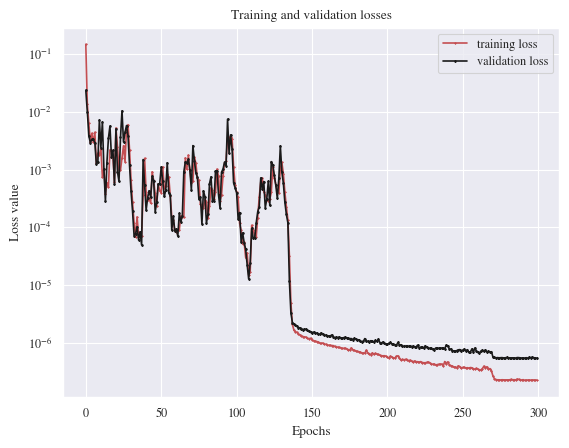

[I 2024-04-25 20:23:02,122] Trial 54 finished with value: 5.41927749240972e-07 and parameters: {'n_layers': 4, 'hidden_nodes': 928, 'gamma': 0.007810298952221274}. Best is trial 45 with value: 3.3237931721427406e-07.


Loss  9.95123201619208e-08
The error on the validation trajectories is: 5.41927749240972e-07.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 3
    hidden_nodes: 928
    gamma: 0.007974361595013486



The average loss in epoch 1 is  0.14367540595545011
The average loss in epoch 2 is  0.013548745879564773
The average loss in epoch 3 is  0.0072252578419548545
The average loss in epoch 4 is  0.003597409570250999
The average loss in epoch 5 is  0.00603881592608311
The average loss in epoch 6 is  0.004837413016833703
The average loss in epoch 7 is  0.004388793752613393
The average loss in epoch 8 is  0.0013671333343319764
The average loss in epoch 9 is  0.0014731897932837126
The average loss in epoch 10 is  0.0009493922460189259
The average loss in epoch 11 is  0.0011851079881043088
The average loss in epoch 12 is  0.003644911436078308
The average loss in epoch 13 is  0.002970774703002958
The average loss in epoch 14 is  0.0006291884928941727
The avera

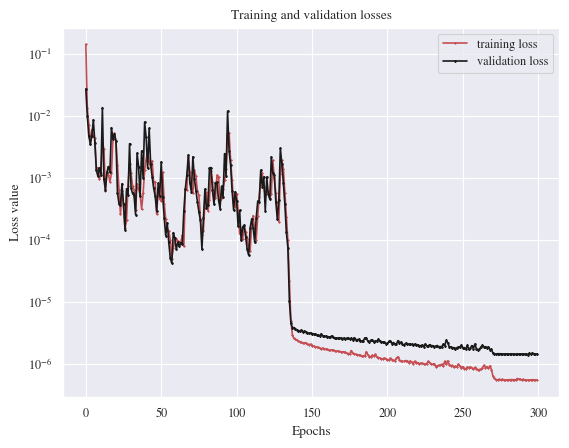

[I 2024-04-25 20:26:25,318] Trial 55 finished with value: 1.45160779839349e-06 and parameters: {'n_layers': 3, 'hidden_nodes': 928, 'gamma': 0.007974361595013486}. Best is trial 45 with value: 3.3237931721427406e-07.


Loss  2.2052374504255567e-07
The error on the validation trajectories is: 1.45160779839349e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 887
    gamma: 0.008513677533399556



The average loss in epoch 1 is  0.1438397868451747
The average loss in epoch 2 is  0.014113275207240473
The average loss in epoch 3 is  0.008054597991180013
The average loss in epoch 4 is  0.003399544009219178
The average loss in epoch 5 is  0.007643852837976407
The average loss in epoch 6 is  0.006055487505033274
The average loss in epoch 7 is  0.004206351798281751
The average loss in epoch 8 is  0.0022006069431716405
The average loss in epoch 9 is  0.0011885985388124193
The average loss in epoch 10 is  0.001782899426127022
The average loss in epoch 11 is  0.0022203232828443024
The average loss in epoch 12 is  0.0006042950309082781
The average loss in epoch 13 is  0.00036011832443446934
The average loss in epoch 14 is  0.0019600477022653317
The av

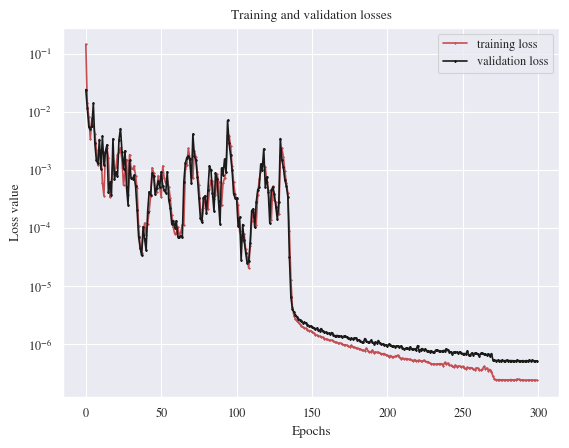

[I 2024-04-25 20:30:00,064] Trial 56 finished with value: 5.202371863161567e-07 and parameters: {'n_layers': 4, 'hidden_nodes': 887, 'gamma': 0.008513677533399556}. Best is trial 45 with value: 3.3237931721427406e-07.


Loss  1.1054122239784192e-07
The error on the validation trajectories is: 5.202371863161567e-07.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 885
    gamma: 0.0078101622274810035



The average loss in epoch 1 is  0.14351326989179308
The average loss in epoch 2 is  0.014497867700728502
The average loss in epoch 3 is  0.007821537025103515
The average loss in epoch 4 is  0.005379901177630844
The average loss in epoch 5 is  0.002452314799566838
The average loss in epoch 6 is  0.003233751250346276
The average loss in epoch 7 is  0.004106343803207644
The average loss in epoch 8 is  0.001447873469177549
The average loss in epoch 9 is  0.0020969262497436084
The average loss in epoch 10 is  0.0018877890252042562
The average loss in epoch 11 is  0.0022236111637374215
The average loss in epoch 12 is  0.0004677283339498734
The average loss in epoch 13 is  0.0024156561418997376
The average loss in epoch 14 is  0.0017359746032690798
The 

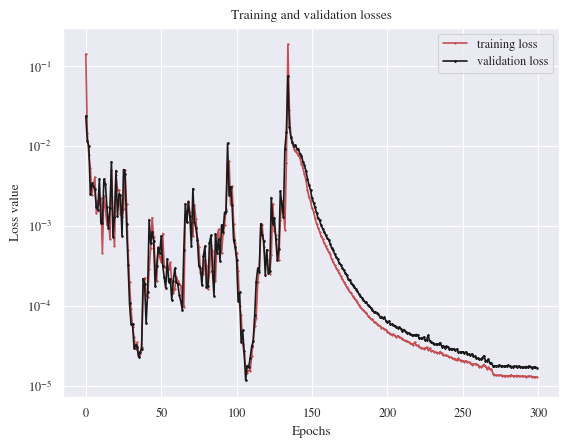

[I 2024-04-25 20:34:12,955] Trial 57 finished with value: 1.682017598285677e-05 and parameters: {'n_layers': 4, 'hidden_nodes': 885, 'gamma': 0.0078101622274810035}. Best is trial 45 with value: 3.3237931721427406e-07.


Loss  1.1988163350906689e-05
The error on the validation trajectories is: 1.682017598285677e-05.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 3
    hidden_nodes: 926
    gamma: 0.008523283096051819



The average loss in epoch 1 is  0.14398837614465843
The average loss in epoch 2 is  0.014219348784536123
The average loss in epoch 3 is  0.00848186669066887
The average loss in epoch 4 is  0.004175634832460095
The average loss in epoch 5 is  0.004892168291421099
The average loss in epoch 6 is  0.003987382790497081
The average loss in epoch 7 is  0.004762576490809972
The average loss in epoch 8 is  0.001413301056758924
The average loss in epoch 9 is  0.0013935597393852236
The average loss in epoch 10 is  0.0008522764507109638
The average loss in epoch 11 is  0.0010245730134722014
The average loss in epoch 12 is  0.0019687432068167254
The average loss in epoch 13 is  0.000784488949152133
The average loss in epoch 14 is  0.001903642674733419
The aver

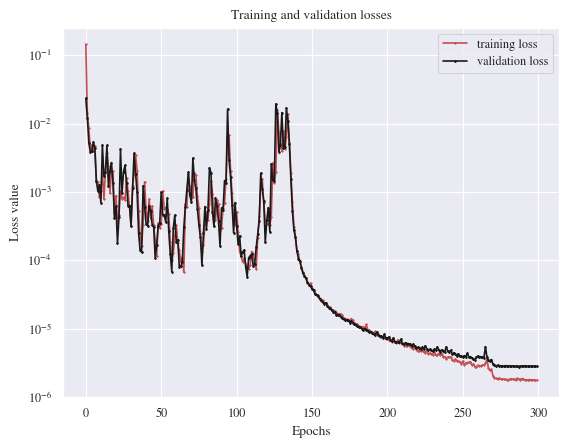

[I 2024-04-25 20:37:32,610] Trial 58 finished with value: 2.800618916441925e-06 and parameters: {'n_layers': 3, 'hidden_nodes': 926, 'gamma': 0.008523283096051819}. Best is trial 45 with value: 3.3237931721427406e-07.


Loss  6.207878868735861e-07
The error on the validation trajectories is: 2.800618916441925e-06.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 853
    gamma: 0.008787091152421564



The average loss in epoch 1 is  0.14936993110247634
The average loss in epoch 2 is  0.016723513730208982
The average loss in epoch 3 is  0.011905937011099675
The average loss in epoch 4 is  0.005648668548515575
The average loss in epoch 5 is  0.004487231352620504
The average loss in epoch 6 is  0.004009518137370998
The average loss in epoch 7 is  0.005772822652943432
The average loss in epoch 8 is  0.002630867394724522
The average loss in epoch 9 is  0.0016424768506443468
The average loss in epoch 10 is  0.0015803566546475684
The average loss in epoch 11 is  0.0020726204304744237
The average loss in epoch 12 is  0.00047813728121003476
The average loss in epoch 13 is  0.0011458774196481418
The average loss in epoch 14 is  0.0015273935410236431
The a

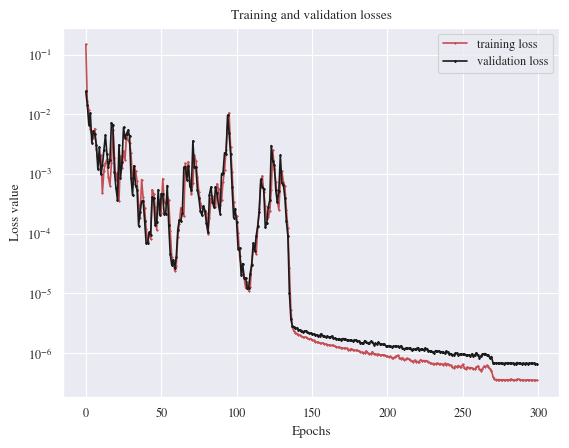

[I 2024-04-25 20:41:24,905] Trial 59 finished with value: 6.580294033411423e-07 and parameters: {'n_layers': 4, 'hidden_nodes': 853, 'gamma': 0.008787091152421564}. Best is trial 45 with value: 3.3237931721427406e-07.


Loss  1.9220445324208413e-07
The error on the validation trajectories is: 6.580294033411423e-07.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 979
    gamma: 0.007140631083096487



The average loss in epoch 1 is  0.14369950536638498
The average loss in epoch 2 is  0.011536139232868498
The average loss in epoch 3 is  0.005863061598078771
The average loss in epoch 4 is  0.0029678111578422513
The average loss in epoch 5 is  0.00509246985364536
The average loss in epoch 6 is  0.004609189509541135
The average loss in epoch 7 is  0.0025450608042195777
The average loss in epoch 8 is  0.000907196572039869
The average loss in epoch 9 is  0.002558947654589164
The average loss in epoch 10 is  0.0026867435715923257
The average loss in epoch 11 is  0.0036477533655918455
The average loss in epoch 12 is  0.0012979006265099583
The average loss in epoch 13 is  0.0018178474036341702
The average loss in epoch 14 is  0.0007169871334388682
The a

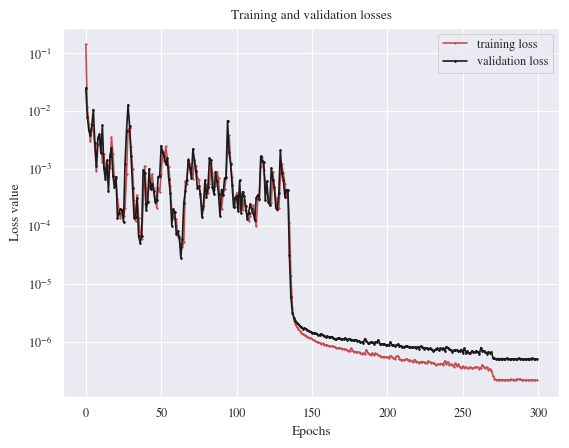

[I 2024-04-25 20:48:10,242] Trial 60 finished with value: 4.994938515394378e-07 and parameters: {'n_layers': 4, 'hidden_nodes': 979, 'gamma': 0.007140631083096487}. Best is trial 45 with value: 3.3237931721427406e-07.


Loss  8.498608394802432e-08
The error on the validation trajectories is: 4.994938515394378e-07.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 983
    gamma: 0.007776104076644974



The average loss in epoch 1 is  0.1467541871931065
The average loss in epoch 2 is  0.013657874618233605
The average loss in epoch 3 is  0.006549331306649203
The average loss in epoch 4 is  0.0026920180587859995
The average loss in epoch 5 is  0.008336970643457871
The average loss in epoch 6 is  0.006675603407943113
The average loss in epoch 7 is  0.007228695295370099
The average loss in epoch 8 is  0.004866761128968475
The average loss in epoch 9 is  0.002179284524490041
The average loss in epoch 10 is  0.0018799467996524816
The average loss in epoch 11 is  0.0016099285620095377
The average loss in epoch 12 is  0.0004961871302591383
The average loss in epoch 13 is  0.0003462705829985101
The average loss in epoch 14 is  0.002233373650100971
The aver

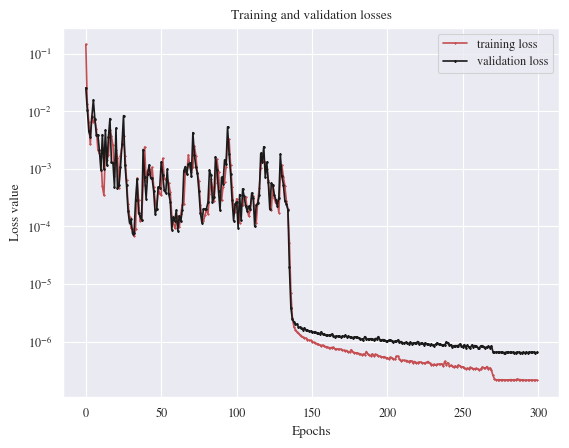

[I 2024-04-25 20:53:24,787] Trial 61 finished with value: 6.445481392790447e-07 and parameters: {'n_layers': 4, 'hidden_nodes': 983, 'gamma': 0.007776104076644974}. Best is trial 45 with value: 3.3237931721427406e-07.


Loss  9.128006439595993e-08
The error on the validation trajectories is: 6.445481392790447e-07.
train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
Current test with :


    n_layers: 4
    hidden_nodes: 960
    gamma: 0.007048554223231833



The average loss in epoch 1 is  0.14356759148226542


[W 2024-04-25 20:53:26,818] Trial 62 failed with parameters: {'n_layers': 4, 'hidden_nodes': 960, 'gamma': 0.007048554223231833} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/t4/p3rsq6254flg_bnmk_p_xgkw0000gn/T/ipykernel_7649/324378338.py", line 29, in objective
    loss = train(model,gamma,criterion,scheduler,optimizer,epochs,trainloader,valloader,device)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/davidemu/Desktop/repos/LearningEulersElastica/DiscreteNetwork/Scripts/Training.py", line 40, in train
    predicted = model(inputs)
               ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwa

The average loss in epoch 2 is  0.013632047159427946


KeyboardInterrupt: 

In [15]:
optuna_study = input("Do you want to do hyperparameter test? Type yes or no: ")
params = {}
if optuna_study=="yes":
    optuna_study = True
else:
    optuna_study = False
if optuna_study:
    study = optuna.create_study(direction="minimize",study_name="Euler Elastica")
    study.optimize(objective, n_trials=300)
    print("Study statistics: ")
    print("Number of finished trials: ", len(study.trials))
    params = study.best_params

In [16]:
percentage_train

0.7

In [17]:
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)

In [18]:
manual_input = False
if params=={}:
    # We can input them manually by uncommenting the lines below
    if manual_input:
        print("No parameters have been specified. Let's input them:\n\n")
        is_res = input("Is_res True or False? ")=="True"
        normalize = input("Normalize is True or False? ")=="True"
        act = input("What activation function to use? Choose among 'sin', 'sigmoid', 'swish', 'tanh' ")
        nlayers = int(input("How many layers do you want the network to have? "))
        hidden_nodes = int(input("How many hidden nodes do you want the network to have? "))
        lr = float(input("What learning rate do you want to use? "))
        weight_decay = float(input("What weight decay do you want to use? "))
        gamma = float(input("What value do you want for gamma? "))
        batch_size = int(input("What batch size do you want? "))

        params = {'is_res': is_res,
                'normalize': normalize,
                'act': act,
                'n_layers': nlayers,
                'hidden_nodes': hidden_nodes,
                'lr': lr,
                'weight_decay': weight_decay,
                'gamma': gamma,
                'batch_size': batch_size}
    else:
    # or we can use the combinations found by Optuna that yield the best results for the mentioned datacases
        params = hyperparams(datacase, percentage_train)

In [19]:
print(f'The hyperparameters yelding the best results for this case are: {params}')

The hyperparameters yelding the best results for this case are: {'is_res': False, 'normalize': False, 'act': 'tanh', 'n_layers': 4, 'hidden_nodes': 950, 'lr': 0.0010197311392830968, 'weight_decay': 1.79067309430248e-06, 'gamma': 0.00859530974114581, 'batch_size': 64}


In [20]:
def define_best_model():
    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)

    normalize = True #params["normalize"]
    act = "tanh" #params["act"]
    nlayers = 4  #params["n_layers"]
    hidden_nodes = 932 #params["hidden_nodes"]
    is_res = False #params["is_res"]
    model = approximate_curve(is_res, normalize, act, nlayers, hidden_nodes, int(4*(num_nodes-2)))

    return model

In [21]:
model = define_best_model()
model.to(device);

In [22]:
TrainMode = input("Train Mode True or False? Type 0 for False and 1 for True: ")
TrainMode = int(TrainMode)
if TrainMode == 0:
    TrainMode = False
else:
    TrainMode = True
TrainMode

True

train :  (690, 8)
val :  (100, 8)
test :  (197, 8)
The average loss in epoch 1 is  0.1436775792390108
The average loss in epoch 2 is  0.013167016398669644
The average loss in epoch 3 is  0.006553259699351408
The average loss in epoch 4 is  0.0029300699772482567
The average loss in epoch 5 is  0.006458174442576075
The average loss in epoch 6 is  0.005677065515721386
The average loss in epoch 7 is  0.0029508913496763193
The average loss in epoch 8 is  0.0009847829695156013
The average loss in epoch 9 is  0.0024446995217162607
The average loss in epoch 10 is  0.0033660197910979728
The average loss in epoch 11 is  0.002120991338002072
The average loss in epoch 12 is  0.0005862654043911872
The average loss in epoch 13 is  0.00038029798452043906
The average loss in epoch 14 is  0.0020209021273661742
The average loss in epoch 15 is  0.002418616752203723
The average loss in epoch 16 is  0.0016933856531977654
The average loss in epoch 17 is  0.0005527881849874658
The average loss in epoch 18 is

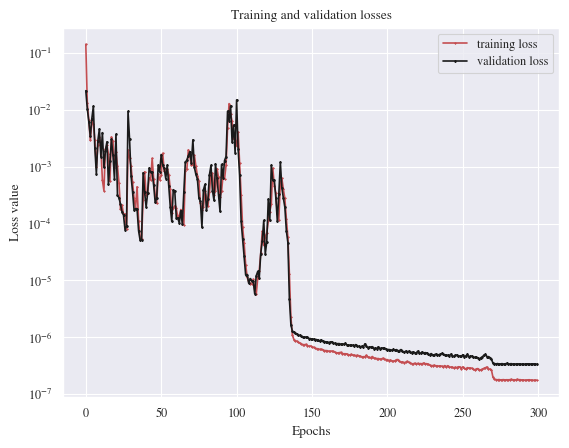

In [24]:
weight_decay = 0. #params["weight_decay"]
lr = 1e-3 #params["lr"]
gamma = 0.00883868653735616 #params["gamma"]
batch_size = 32 #params["batch_size"]
epochs = 300
optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = int(0.45*epochs), gamma = 0.1)
criterion = nn.MSELoss()
x_train, y_train, x_test, y_test, x_val, y_val,trainloader, testloader,valloader = getDataLoaders(batch_size, datacase, percentage_train)
model.to(device);

if TrainMode:
    loss = train(model,gamma,criterion,scheduler,optimizer,epochs,trainloader,valloader,device)
    if datacase == 1:
        if percentage_train == 0.9:
            torch.save(model.state_dict(), 'TrainedModels/BothEnds0.9data.pt')
        elif percentage_train == 0.4:
            torch.save(model.state_dict(), 'TrainedModels/BothEnds0.4data.pt')
        elif percentage_train == 0.2:
            torch.save(model.state_dict(), 'TrainedModels/BothEnds0.2data.pt')
        else:
            torch.save(model.state_dict(), 'TrainedModels/BothEnds0.1data.pt')
    if datacase == 2:
        torch.save(model.state_dict(), 'TrainedModels/BothEndsExtrapolation0.9data.pt')
    if datacase == 3:
        torch.save(model.state_dict(), 'TrainedModels/BothEndsRightEnd0.9data.pt')
else:
    if datacase == 1:
        if percentage_train == 0.9:
            pretrained_dict = torch.load(f'TrainedModels/BothEnds0.9data.pt',map_location=device)
        elif percentage_train == 0.4:
            pretrained_dict = torch.load(f'TrainedModels/BothEnds0.4data.pt',map_location=device)
        elif percentage_train == 0.2:
            pretrained_dict = torch.load(f'TrainedModels/BothEnds0.2data.pt',map_location=device)
        else:
            pretrained_dict = torch.load(f'TrainedModels/BothEnds0.1data.pt',map_location=device)
    if datacase == 2:
        pretrained_dict = torch.load(f'TrainedModels/BothEndsExtrapolation0.9data.pt',map_location=device)
    if datacase == 3:
        pretrained_dict = torch.load(f'TrainedModels/BothEndsRightEnd0.9data.pt',map_location=device)
    model.load_state_dict(pretrained_dict)
model.eval();

In [25]:
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)

model.eval();

In [28]:
def plotResults(model, device, x_train, y_train, x_test, y_test, num_nodes, datacase, percentage_train):

    train_bcs = torch.from_numpy(x_train.astype(np.float32)).to(device)
    test_bcs = torch.from_numpy(x_test.astype(np.float32)).to(device)

    pred_train = np.concatenate((x_train[:, :4], model(train_bcs).detach().cpu().numpy(), x_train[:, -4:]), axis = 1)
    pred_test = np.concatenate((x_test[:, :4], model(test_bcs).detach().cpu().numpy(), x_test[:, -4:]), axis = 1)

    true_train = np.concatenate((x_train[:, :4], y_train, x_train[:, -4:]), axis = 1)
    true_test = np.concatenate((x_test[:, :4], y_test, x_test[:, -4:]), axis = 1)

    pred = np.concatenate((pred_train[:,4:-4], pred_test[:,4:-4]), axis = 0)
    true = np.concatenate((true_train[:,4:-4], true_test[:,4:-4]), axis = 0)
    error_all = np.mean((pred - true)**2)
    error_training = np.mean((pred_train[:,4:-4] - true_train[:,4:-4])**2)
    error_testing = np.mean((pred_test[:,4:-4] - true_test[:,4:-4])**2)

    print(f"\n Error over training trajectories: {error_training}, \n Error over test trajectories: {error_testing}, \n Error over all trajectories: {error_all}.")

    c, d = pred_test.shape

    norms_q = np.zeros((len(pred_test), num_nodes))
    mean_q = np.zeros(num_nodes)
    norms_qp = np.zeros((len(pred_test), num_nodes))
    mean_qp = np.zeros(num_nodes)
    for i in range(len(pred_test)):
        for j in range(num_nodes):
            norms_q[i, j] = np.linalg.norm(pred_test[i, 4*j:4*j+2] - true_test[i,4*j:4*j+2])
            mean_q[j] = np.mean(norms_q[:, j])
            norms_qp[i, j] = np.linalg.norm(pred_test[i, 4*j+2:4*j+4] - true_test[i,4*j+2:4*j+4])
            mean_qp[j] = np.mean(norms_qp[:, j])
                
    if datacase == 1:
        if percentage_train == 0.7 or percentage_train == 0.8:
            fig1 = plt.figure(figsize = ((20, 15)))
            for i in range(1):
                plt.plot(true_test[i, np.arange(0, d, 4)], true_test[i, np.arange(1, d, 4)], '-', linewidth = 3, color = 'k', label = 'True')
                plt.plot(pred_test[i, np.arange(0, d, 4)], pred_test[i, np.arange(1, d, 4)], '--d', markersize = 5, linewidth = 1.8, color = 'r', label = 'Predicted')
            for i in np.arange(1,c,11): #remove ",11" from np.arange if you want to plot all test trajectories
                plt.plot(true_test[i, np.arange(0, d, 4)], true_test[i, np.arange(1, d, 4)], '-', linewidth = 3, color = 'k')
                plt.plot(pred_test[i, np.arange(0, d, 4)], pred_test[i, np.arange(1, d, 4)], '--d', markersize = 5, linewidth = 1.8, color = 'r')
            plt.xlabel(r"$q_x$", fontsize = "45")
            plt.ylabel(r"$q_y$", fontsize = "45")
            plt.tick_params(labelsize = "45")
            plt.legend(fontsize = "45", loc = 'best')
            plt.title(r"Comparison over test trajectories $(q_x, q_y)$", fontsize = "45")
            plt.savefig("q.pdf")
            plt.show()

            fig2 = plt.figure(figsize = ((20, 15)))
            for i in range(1):
                plt.scatter(true_test[i, np.arange(2, d, 4)], true_test[i, np.arange(3, d, 4)], color = 'k', s = 90, label = 'True')
                plt.scatter(pred_test[i, np.arange(2, d, 4)], pred_test[i, np.arange(3, d, 4)], color = 'r', s = 30, label = 'Predicted')
            for i in np.arange(1,c,11): #remove ",11" from np.arange if you want to plot all test trajectories
                plt.scatter(true_test[i, np.arange(2, d, 4)], true_test[i, np.arange(3, d, 4)], color = 'k', s = 90)
                plt.scatter(pred_test[i, np.arange(2, d, 4)], pred_test[i, np.arange(3, d, 4)], color = 'r', s = 30)
            plt.xlabel(r"$q^{\prime}_x$", fontsize = "45")
            plt.ylabel(r"$q^{\prime}_y$", fontsize = "45")
            plt.tick_params(labelsize = "45")
            plt.axis('equal')
            plt.title(r"Comparison over test trajectories $(q^{\prime}_x, q^{\prime}_y)$", fontsize = "45")
            plt.legend(fontsize = "45", loc = 'center')
            plt.savefig("qprime.pdf")
            plt.show()

            fig3 = plt.figure(figsize = ((20, 15)))
            plt.plot(np.linspace(0, 50, 51), mean_q, '-d', linewidth = 2, color = 'k', label = r"Error on $(q_x, q_y)$ ")
            plt.plot(np.linspace(0, 50, 51), mean_qp, '-d', linewidth = 2, color = 'r', label = r"Error on $(q^{\prime}_x, q^{\prime}_y)$")
            plt.xlabel(r"node $k$", fontsize = "45")
            plt.ylabel(r"Average norm of error", fontsize = "45")
            plt.tick_params(labelsize = "45")
            plt.title(r"Mean error over test trajectories", fontsize = "45")
            plt.legend(fontsize = "45", loc = 'best')
            plt.savefig("error.pdf")
            plt.show()

    
    if datacase == 3:
        fig1 = plt.figure(figsize = ((20, 15)))
        for i in range(1):
            plt.plot(true_test[i, np.arange(0, d, 4)], true_test[i, np.arange(1, d, 4)], '-', linewidth = 3, color = 'k', label = 'True')
            plt.plot(pred_test[i, np.arange(0, d, 4)], pred_test[i, np.arange(1, d, 4)], '--d', markersize = 5, linewidth = 1.8, color = 'r', label = 'Predicted')
        for i in np.arange(2,c,22): #remove ",22" from np.arange if you want to plot all test trajectories
            plt.plot(true_test[i, np.arange(0, d, 4)], true_test[i, np.arange(1, d, 4)], '-', linewidth = 3, color = 'k')
            plt.plot(pred_test[i, np.arange(0, d, 4)], pred_test[i, np.arange(1, d, 4)], '--d', markersize = 5, linewidth = 1.8, color = 'r')
        plt.xlabel(r"$q_x$", fontsize = "45")
        plt.ylabel(r"$q_y$", fontsize = "45")
        plt.tick_params(labelsize = "45")
        plt.legend(fontsize = "45", loc = 'best')
        plt.title(r"Comparison over test trajectories $(q_x, q_y)$", fontsize = "45")
        plt.show()

        fig2 = plt.figure(figsize = ((20, 15)))
        for i in range(1):
            plt.scatter(true_test[i, np.arange(2, d, 4)], true_test[i, np.arange(3, d, 4)], color = 'k', s = 90, label = 'True')
            plt.scatter(pred_test[i, np.arange(2, d, 4)], pred_test[i, np.arange(3, d, 4)], color = 'r', s = 30, label = 'Predicted')
        for i in np.arange(2,c,22): #remove ",22" from np.arange if you want to plot all test trajectories
            plt.scatter(true_test[i, np.arange(2, d, 4)], true_test[i, np.arange(3, d, 4)], color = 'k', s = 90)
            plt.scatter(pred_test[i, np.arange(2, d, 4)], pred_test[i, np.arange(3, d, 4)], color = 'r', s = 30)
        plt.xlabel(r"$q^{\prime}_x$", fontsize = "45")
        plt.ylabel(r"$q^{\prime}_y$", fontsize = "45")
        plt.tick_params(labelsize = "45")
        plt.axis('equal')
        plt.title(r"Comparison over test trajectories $(q^{\prime}_x, q^{\prime}_y)$", fontsize = "45")
        plt.legend(fontsize = "45", loc = 'center')
        plt.show()

        fig3 = plt.figure(figsize = ((20, 15)))
        plt.plot(np.linspace(0, 50, 51), mean_q, '-d', linewidth = 2, color = 'k', label = r"Error on $(q_x, q_y)$ ")
        plt.plot(np.linspace(0, 50, 51), mean_qp, '-d', linewidth = 2, color = 'r', label = r"Error on $(q^{\prime}_x, q^{\prime}_y)$")
        plt.xlabel(r"node $k$", fontsize = "45")
        plt.ylabel(r"Average norm of error", fontsize = "45")
        plt.tick_params(labelsize = "45")
        plt.title(r"Mean error over test trajectories", fontsize = "45")
        plt.legend(fontsize = "45", loc = 'best')
        plt.show()


 Error over training trajectories: 1.7076379240385688e-07, 
 Error over test trajectories: 7.333049231205892e-07, 
 Error over all trajectories: 2.957024651785991e-07.


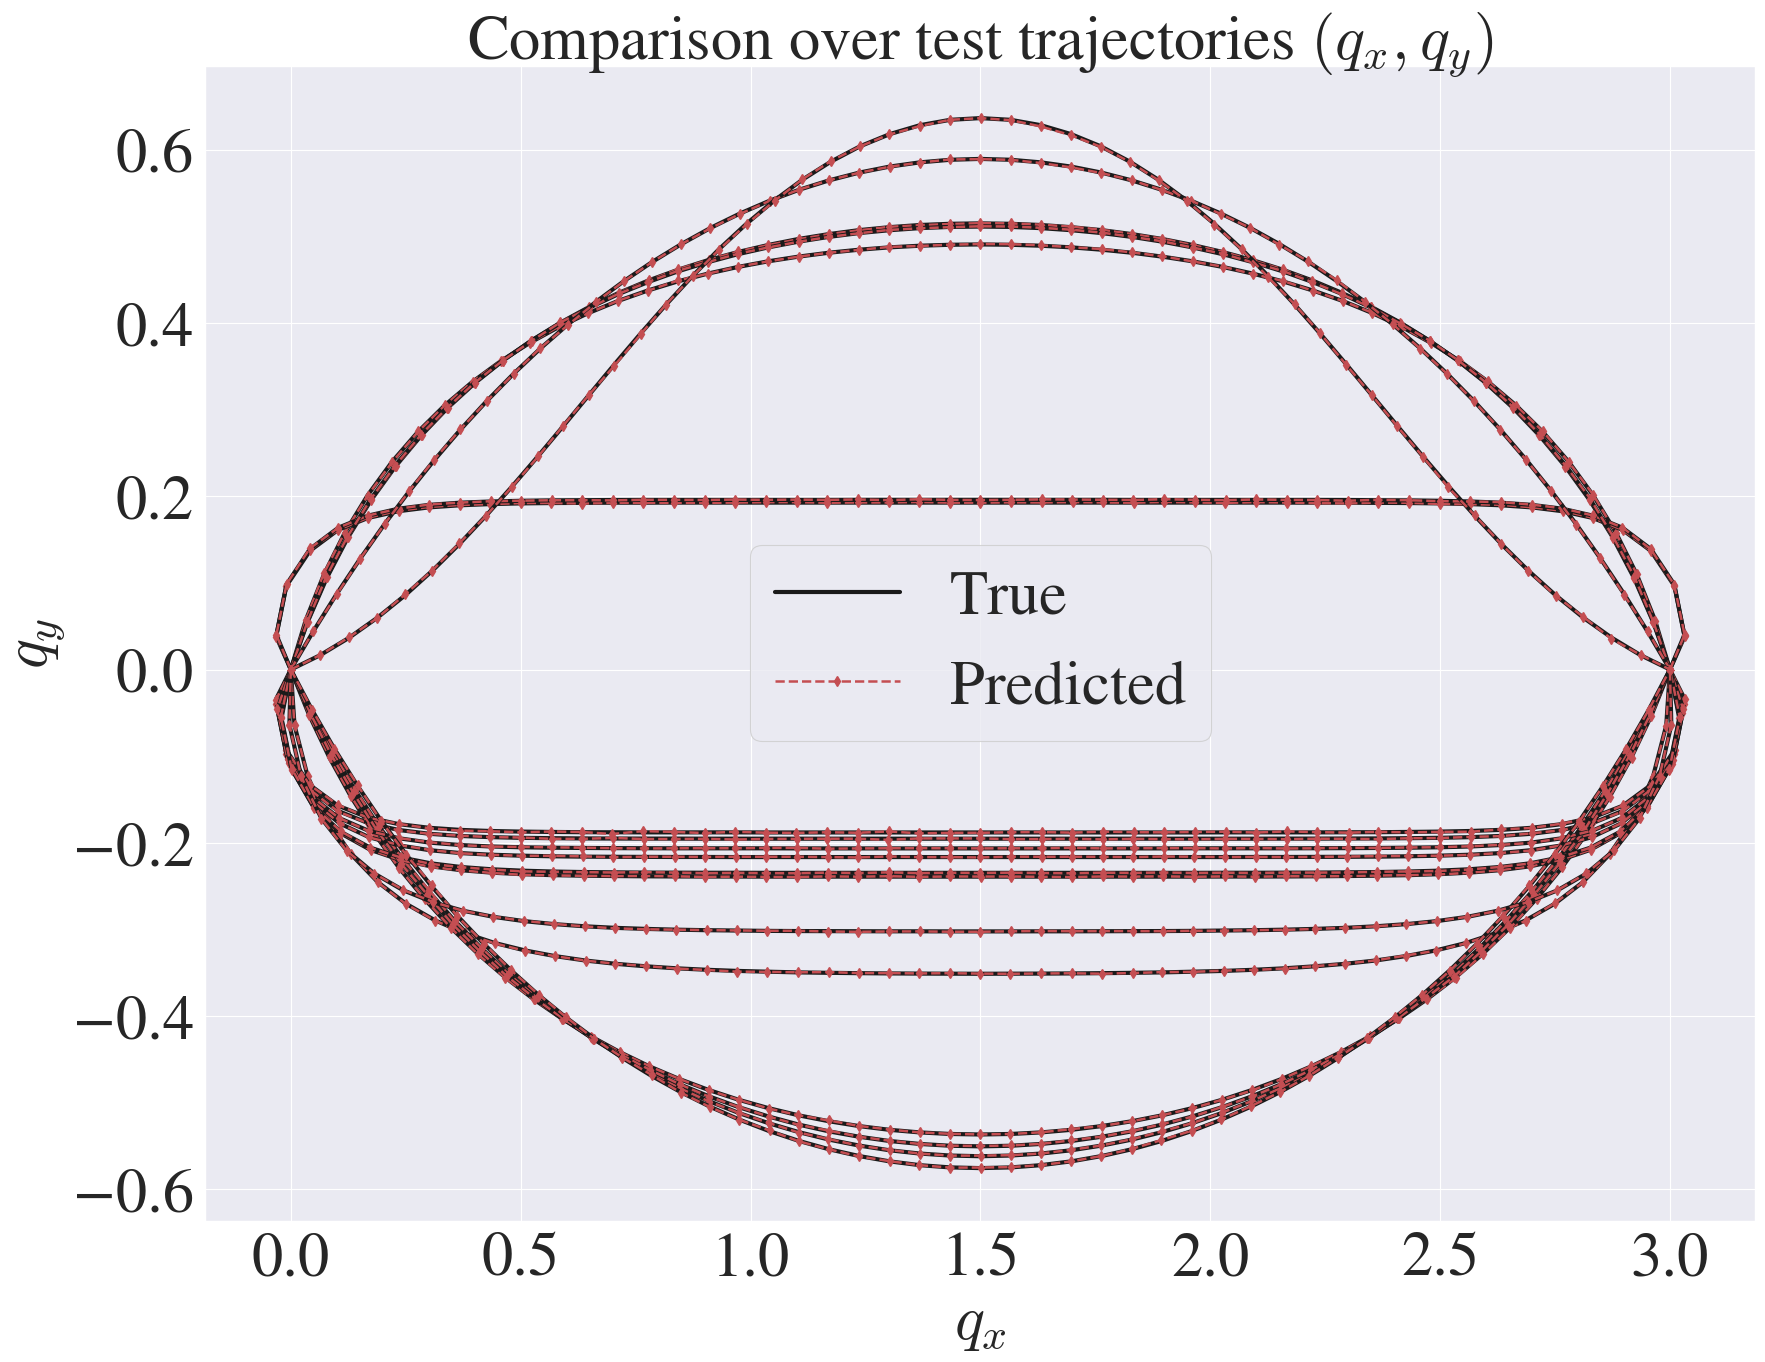

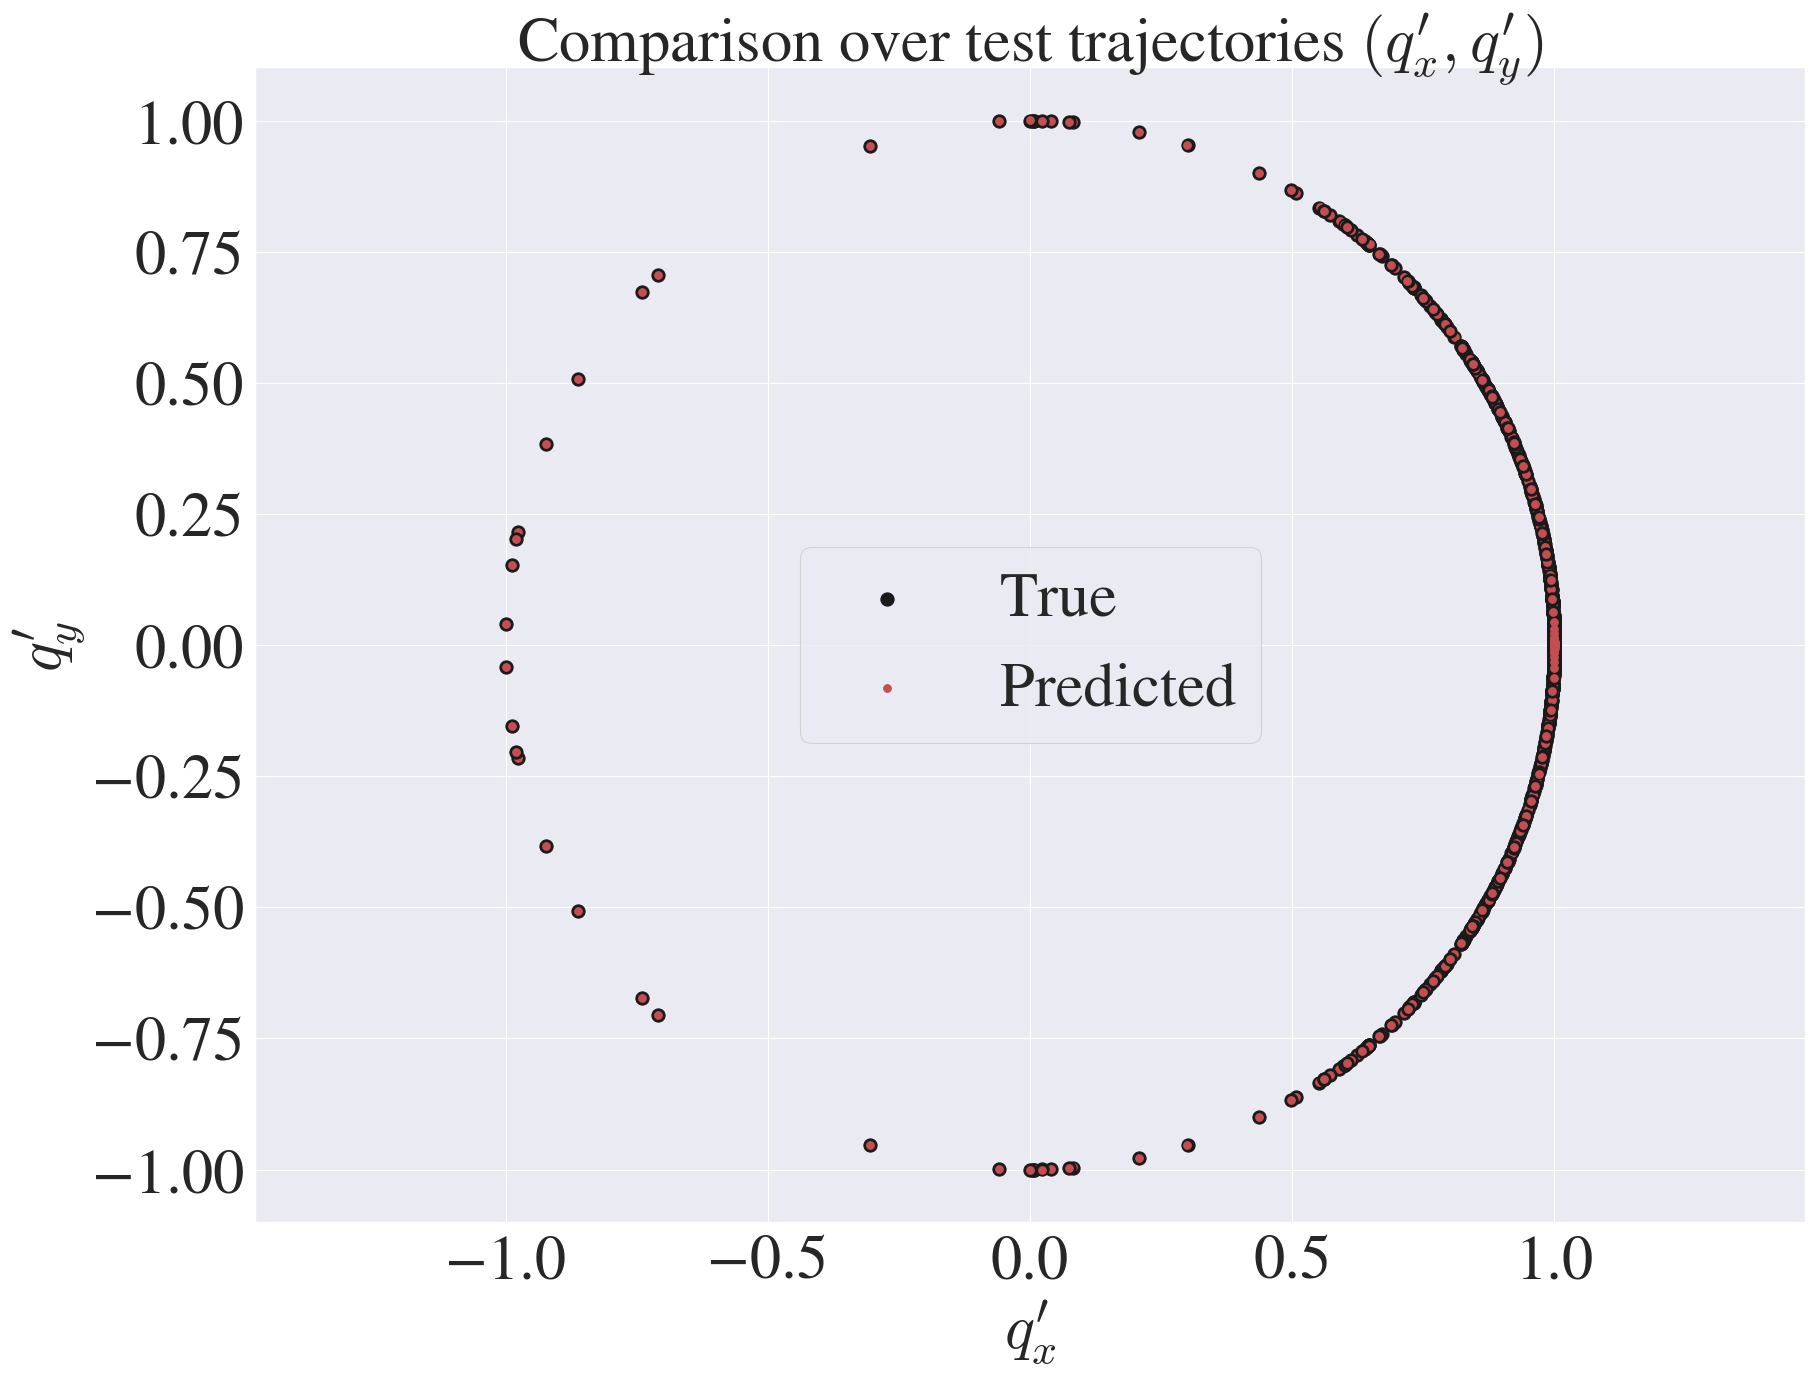

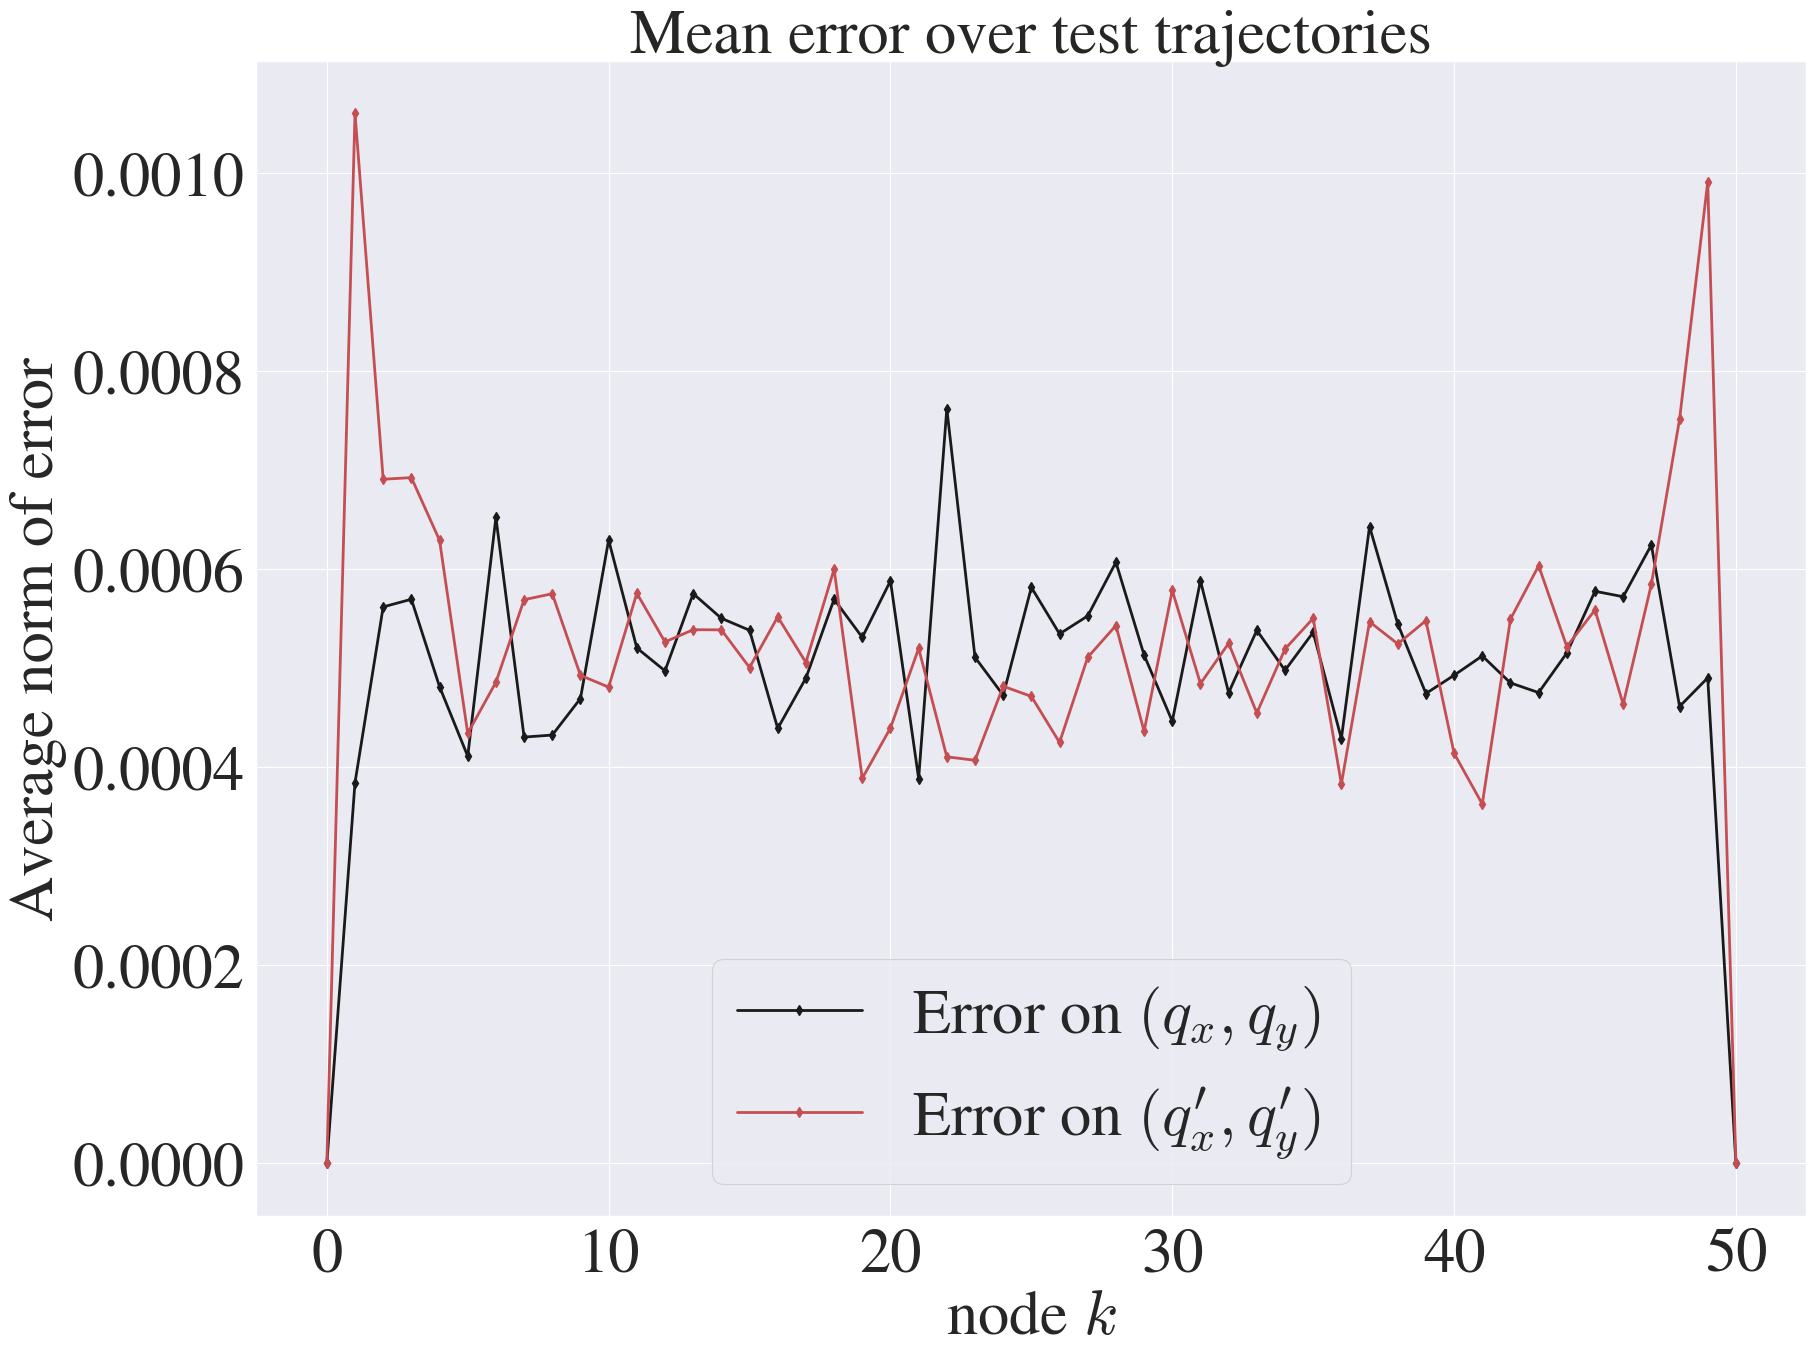

In [29]:
# printing the accuracies and plotting the results
plotResults(model, device, x_train, y_train, x_test, y_test, num_nodes, datacase, percentage_train)